In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import colormaps
from matplotlib.lines import Line2D
from IPython.display import Image
#check version pandas

# Seaborn is a cool library to use whenever starting data exploration
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 6, 6
plt.rc("font", size=18)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Data exploration
## Table Of Content:
* [**"generic" sklearn usage**](#sklearn-generic)
* [**Data prepartion for ML**](#first-bullet)
    * [First look at the data](#FL-bullet)
    * [Value transformation and variance stabilization](#TR-bullet)
    * [Missing Values](#MV-bullet)
    * [Checking Types](#TY-bullet)
    * [OneHot Encoding](#OH-bullet)

* [**Dimensionality reduction/Embedding**](#fourth-bullet)
    * [Principal component analysis](#PCA-bullet)
    * [PCA for immunogenicity dataset](#PCAi-bullet)
    * [t-SNE](#tsne-bullet)     
       
* [**Appendix**](#appendix-bullet)
    * [Whitening](#whiten-bullet)
    * [UMAP](#umap-bullet)
    * [Independant component analysis](#ICA-bullet)
    * [PCA for breast cancer data](#bc-bullet)
    * [PCA for Iris data](#iris-bullet)
    * [Looking at sklearn code](#code-bullet)
    

# "generic" sklearn usage <a id='sklearn-generic'></a>

The main library we will be using for machine learning is scikit-learn.

It should go without saying that if you have any questions regarding its usage and capabilities, your first stop should be their [website](https://scikit-learn.org/stable/),
especially since it provides plenty of [examples](https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html#sphx-glr-auto-examples-ensemble-plot-voting-decision-regions-py), [guides](https://scikit-learn.org/stable/user_guide.html), and [tutorials](https://scikit-learn.org/stable/tutorial/index.html#tutorial-menu).

Nevertheless, we introduce here the most common behavior of sklearn object.

Indeed, sklearn implement machine learning algorithms (random forest, clustering algorithm,...), as well as all kinds of preprocessers (scalin, missing value imputation,...) with a fairly consistent interface.

Most methods must first be instanciated as an object from a specific class:

```python
## import the class, here RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

## instanciate the class object:
my_clf = RandomForestClassifier()
```

As it stands, the object is just a "naive" version of the algorithm.

The next step is then to feed the object data, so it can learn from it. This is done with the `.fit` method:

```python
my_clf.fit( X , y )
```
> In this context, `X` is the data and `y` is the objective to attain. When the object is not an ML algorithm but a preprocessor, you only give the `X`

Now that the object has been trained with your data, you can use it. For instance, to:
* `.transform` your data (typically in the case of a preprocessor)
* `.predict` some output from data (typically in the case of an ML algorithm, like a classifier)

```python
y_predicted = clf.predict(X)  # predict classes of the training data

## OR 

X_scaled = myScaler.transform(X)  # apply a transformation to the data
```

Last but not least, it is common in example code to "fit and transform" a preprocesser in the same line using `.fit_transform`

```python
X_scaled = myNaiveScaler.fit_transform(X)  # equivalent to myNaiveScaler.fit(X).transform(X)
```

That's the basics. You will be able to experiment at length with this and go well beyond it.

<br>

# Data prepartion for ML <a class="anchor" id="first-bullet"></a>

### First look at the data <a class="anchor" id="FL-bullet"></a>

In this intoduction we are using a yeast Phospho proteomics dataset [Plank et al. MCP, 2020](https://doi.org/10.1074/mcp.RA120.001955). The study performed a LC-MS/MS experiment and label-free quantitation to study the effect of AGC-kinase (Sch9, Pka1, Ypk1) inhibition on the phosphoproteome. 5 yeast strains were used: WT, and Sch9, Pka1, Sch9&Pka1, Ypk1 mutant strains. Sch9, Pka1, Ypk1 were mutated in order to allow the 1NMPP1 molecule to bind to the mutant and inhibit its active site. DMSO was used as a control. All measurements were performed in 3 technical replicates.

In [2]:
df_ph = pd.read_excel('../data/Phospho_TOR_inhib.xls', sheet_name='Phospho_TOR_inhib',header=0)
df_ph.head()

Peptide sequence Phosphosites Standard name       WT_DMSO  \
0        ADDEEDLS(Phospho)DENIQPELR         S720          ABF1  1.291531e+08   
1       NVVDENLINDMDS(Phospho)EDAHK         S618          ABF1  0.000000e+00   
2                 SNS(Phospho)IDYAK         S467          ABF1  9.528159e+06   
3                  AST(Phospho)PPVK         T157          ABP1  0.000000e+00   
4  KEPVKT(Phospho)PS(Phospho)PAPAAK    T181 S183          ABP1  1.794915e+07   

      WT_DMSO.1     WT_DMSO.2     WT_1NMPP1   WT_1NMPP1.1   WT_1NMPP1.2  \
0  1.378099e+08  1.264078e+08  1.093194e+08  1.207158e+08  1.143397e+08   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  9.008914e+06  8.909709e+06  9.653322e+06  8.720282e+06  9.312677e+06   
3  0.000000e+00  0.000000e+00  6.426355e+05  5.563823e+05  7.040516e+05   
4  1.813076e+07  1.651690e+07  1.630399e+07  1.657684e+07  1.456594e+06   

      Sch9_DMSO  ...  Sch9_Pka1_DMSO.2  Sch9_Pka1_1NMPP1  Sch9_Pka1_1NMPP1.1  \
0  1.178994e+08  ...      1.292352e+08      1.150856e+08        1.289056e+08   
1  0.000000e+00  ...      0.000000e+00      0.000000e+00        8.857596e+06   
2  1.167629e+07  ...      8.144665e+06      1.424212e+07        1.518253e+07   
3  0.000000e+00  ...      0.000000e+00      0.000000e+00        0.000000e+00   
4  0.000000e+00  ...      0.000000e+00      1.015874e+08        8.166463e+07   

   Sch9_Pka1_1NMPP1.2     Ypk1_DMSO   Ypk1_DMSO.1   Ypk1_DMSO.2   Ypk1_1NMPP1  \
0        1.246350e+08  1.027790e+08  9.492511e+07  9.892962e+07  9.760830e+07   
1        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2        1.120638e+07  4.292957e+06  4.453389e+06  5.198223e+06  4.205676e+06   
3        0.000000e+00  0.000000e+00  0.000000e+00  5.659378e+05  1.221233e+06   
4        8.378514e+07  0.000000e+00  0.000000e+00  4.784055e+07  5.243548e+07   

   Ypk1_1NMPP1.1  Ypk1_1NMPP1.2  
0   1.005682e+08   1.023071e+08  
1   0.000000e+00   0.000000e+00  
2   4.287624e+06   6.059179e+06  
3   0.000000e+00   0.000000e+00  
4   5.166661e+07   6.010725e+07  

[5 rows x 33 columns]

We can look at the reproducibility of the resplicates using seaborn `pairplot`.

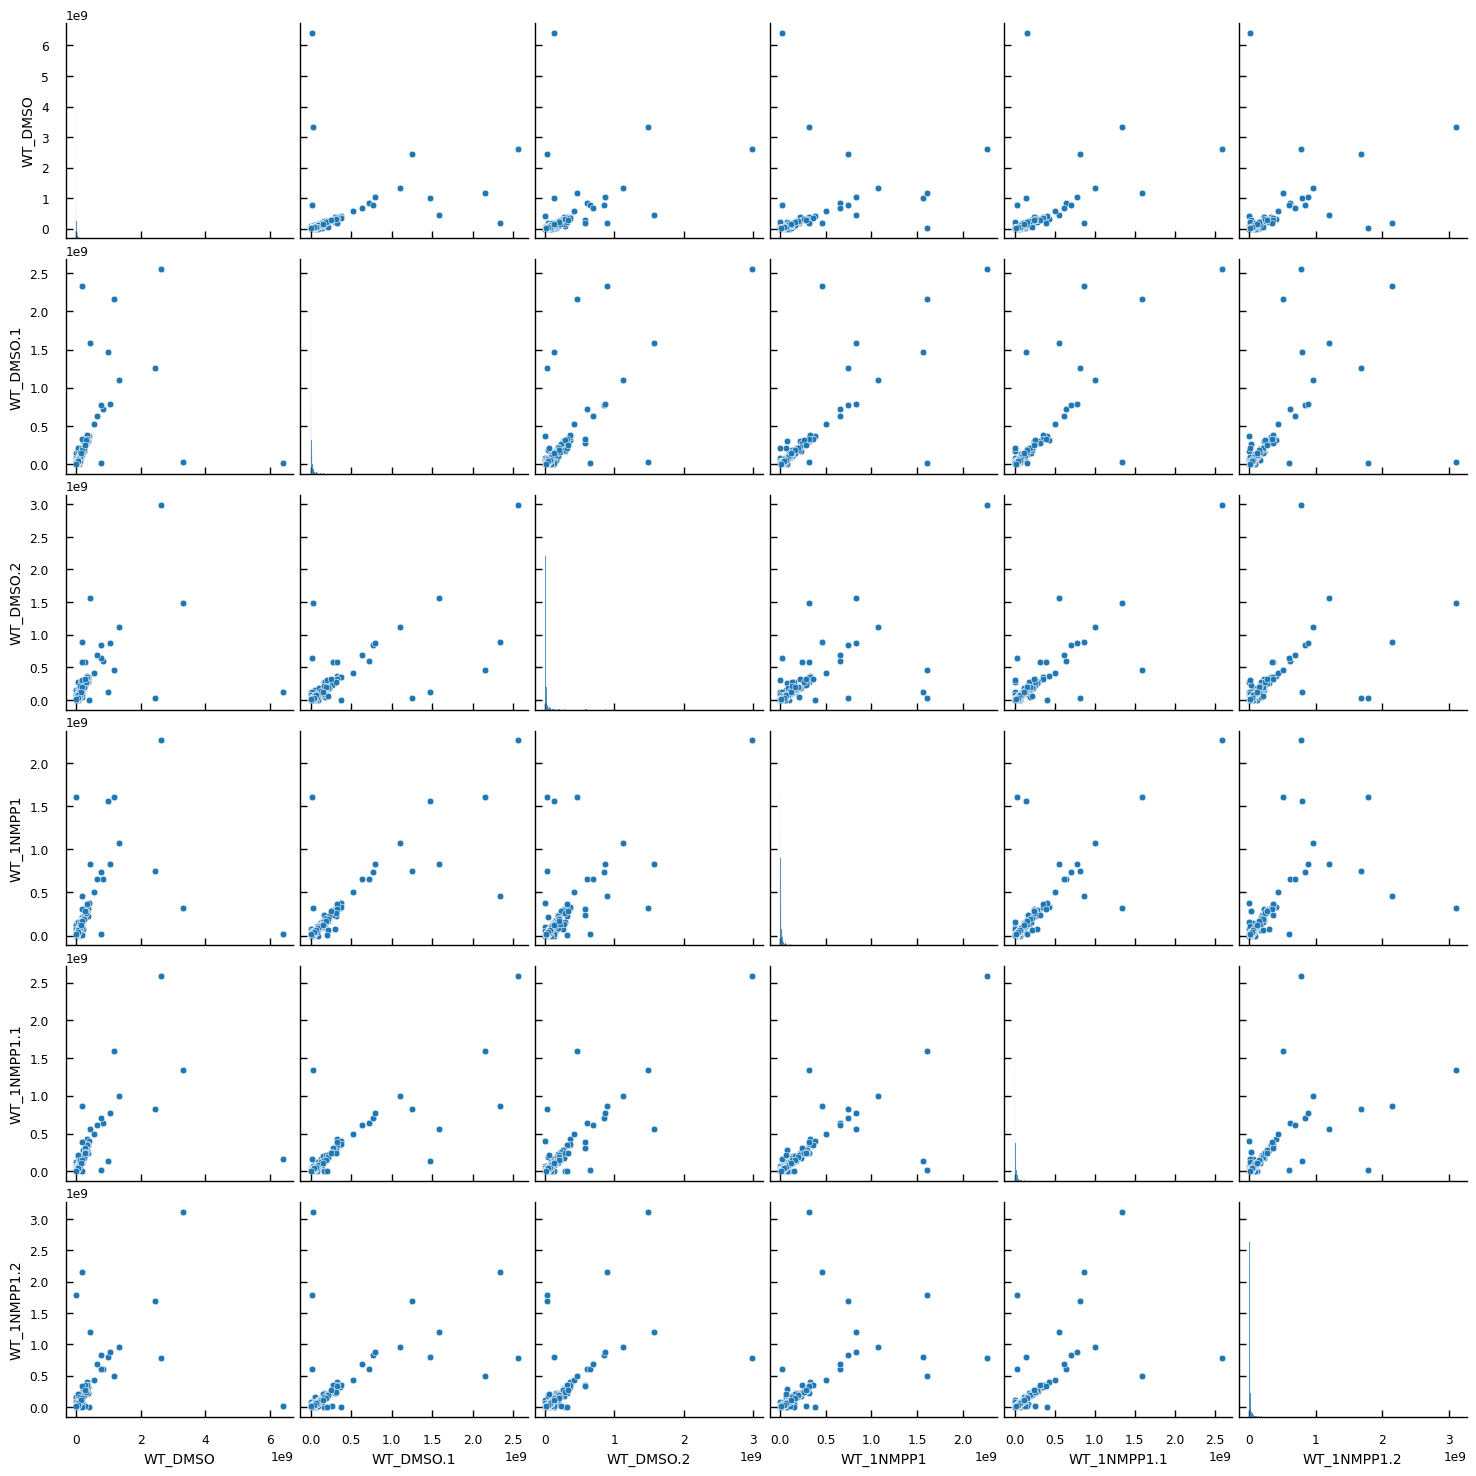

In [3]:
X_ph = df_ph.iloc[:,3:]
sns.set_context("paper", rc={"axes.labelsize":10})
sns.pairplot(X_ph.iloc[:,0:6])

This plot shows an important characteristics of the data: The scatter of the points increases with increasing MS1 intensity values, which is a common feature in quantitative proteomics (and other omics) data. 

We can address this by log-transforming the intensity values, which stabilizes the variance i.e. the scatter or variance will be constant or depend less on the values. This is a desirable feature which makes subsequent data analysis (e.g. t-tests) easier.

### Value transformation and variance stabilization <a class="anchor" id="TR-bullet"></a>

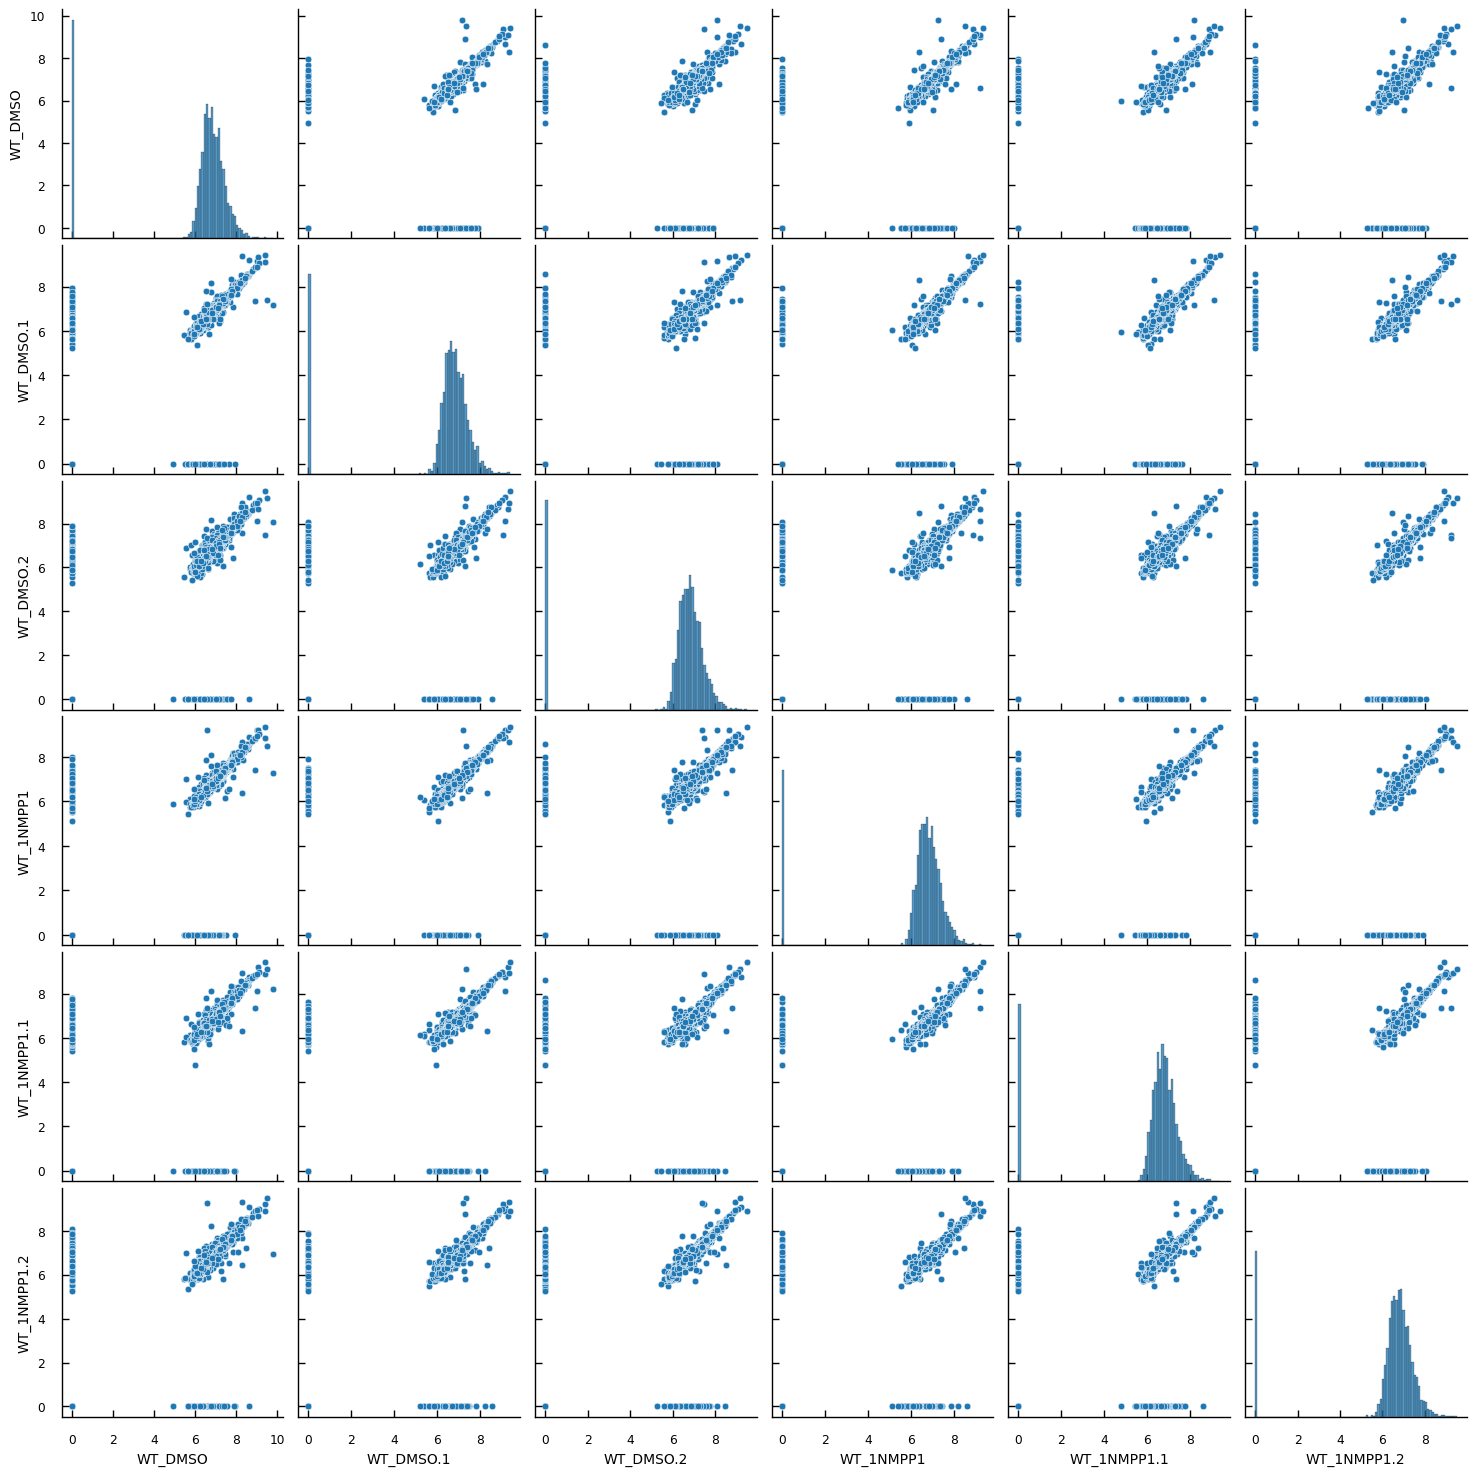

In [4]:
X_ph = X_ph.transform(lambda x: np.log10(x + 1))
sns.set_context("paper", rc={"axes.labelsize":10})
sns.pairplot(X_ph.iloc[:,0:6])

### Missing Values <a class="anchor" id="MV-bullet"></a>

The scatter of the points does not seem to depend anymore on the log-intensity value. The log-intensities are more evenly distributed compared to the raw intensities. The missing or zero values are clearly separated from the positive values. Missing values are common in proteomics data. They are caused by the limited sensitivity of the mass spectrometers or inaccuracies in the computational data processing.

In order to get a better look at the entire dataset, we plot the data as a heatmap:

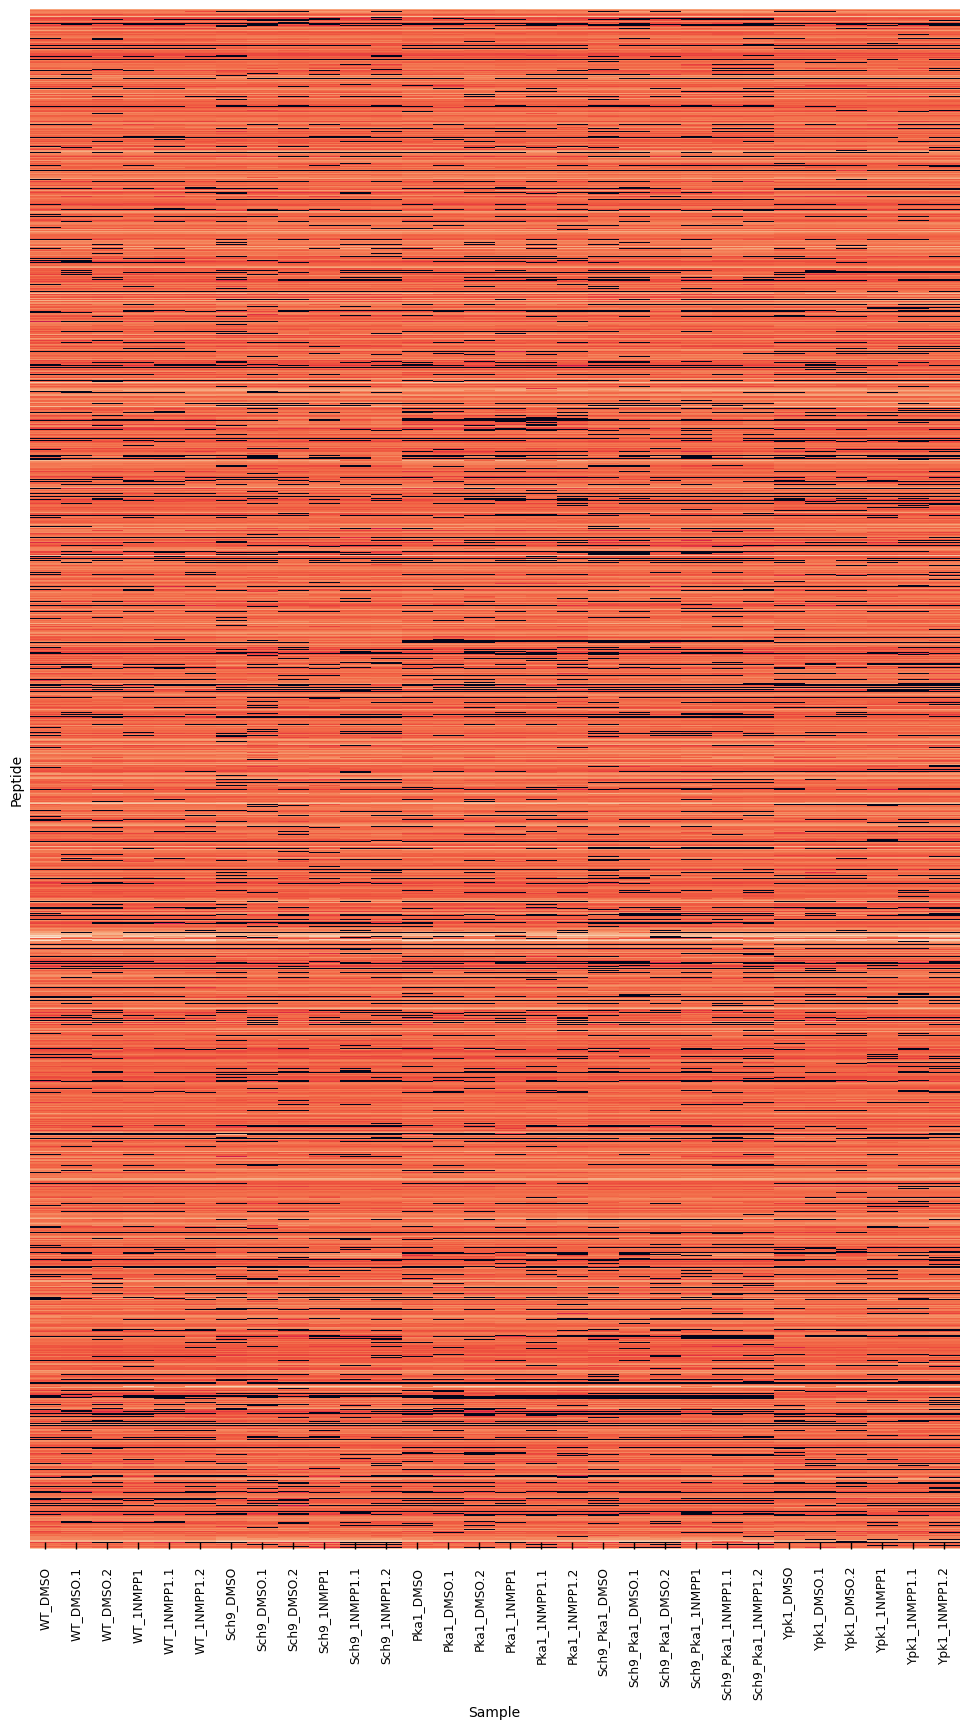

In [5]:
plt.figure(figsize=(12,20))
#X_ph.set_index(df_ph['Peptide sequence'], inplace=True)
ax = sns.heatmap(X_ph, cbar=False,yticklabels=False)
plt.xlabel("Sample")
plt.ylabel("Peptide")
plt.show()

This shows that the missing or zero values (dark lines) are ubiquitous. 

The missing values are not randomly distributed but more likely for low intensity peptides: the average peptide intensity decreases with increasing number of missing values per peptide. 

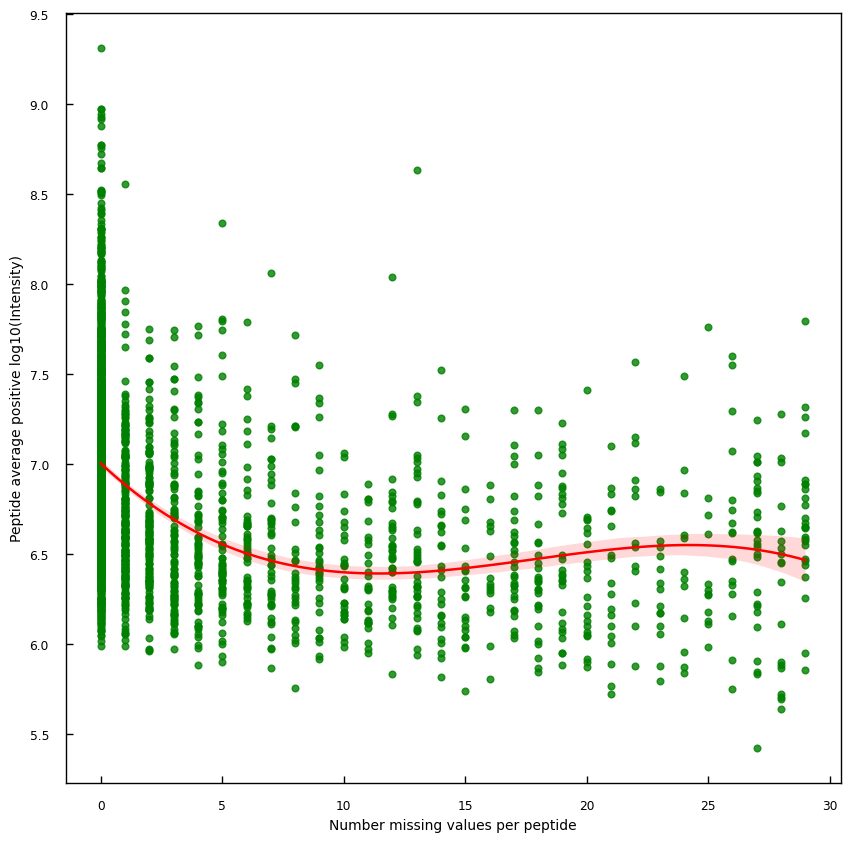

In [6]:
avg = X_ph[X_ph>0].mean(axis=1)
nr_missing = (X_ph==0).sum(axis=1)

plt.figure(figsize=(10,10))
sns.regplot(x=nr_missing, y=avg, order=3, color="g",line_kws={'color':"red"})
plt.ylabel('Peptide average positive log10(Intensity)')
plt.xlabel('Number missing values per peptide')
plt.show(block=False)

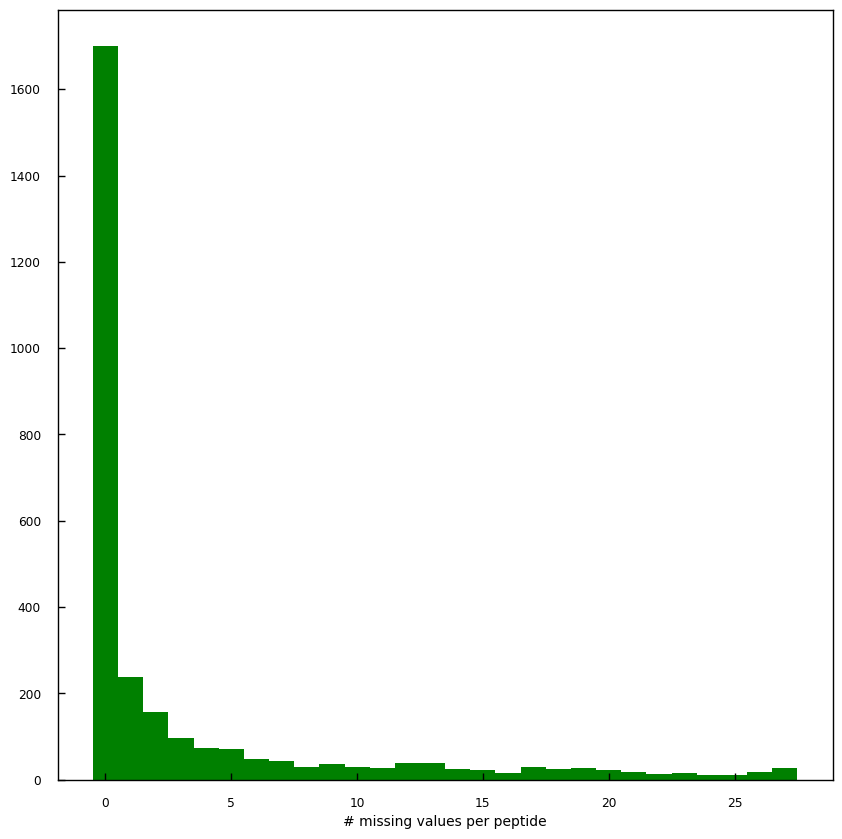

In [7]:
nr_missing = (X_ph==0).sum(axis=1)
plt.figure(figsize=(10,10))
plt.hist(nr_missing, color="g",bins=np.arange(0,29)-0.5)
plt.xlabel("# missing values per peptide")
plt.show()

They are many ways to deal with missing values. The simplest strategies are just to remove all peptides that contain a missing value or to impute a mean positive value for all zero values.

Most of the peptides have zero missing values and discarding all peptides with missing values is not an optimal, but feasible strategy for these data. 

In [8]:
X_ph_positive = X_ph[(X_ph>0).all(axis=1)]
X_ph_positive.head()

WT_DMSO  WT_DMSO.1  WT_DMSO.2  WT_1NMPP1  WT_1NMPP1.1  WT_1NMPP1.2  \
0  8.111105   8.139281   8.101774   8.038697     8.081764     8.058197   
2  6.979009   6.954673   6.949864   6.984677     6.940531     6.969075   
5  7.376958   7.277585   7.236313   7.379282     7.286498     7.263972   
6  6.157649   6.020137   6.151031   6.146390     6.070549     6.110564   
7  7.088574   7.040337   7.016449   7.006731     6.976935     6.977722   

   Sch9_DMSO  Sch9_DMSO.1  Sch9_DMSO.2  Sch9_1NMPP1  ...  Sch9_Pka1_DMSO.2  \
0   8.071512     8.165305     8.080783     8.132232  ...          8.111381   
2   7.067305     7.071589     6.999701     7.135595  ...          6.910873   
5   7.633745     7.687869     7.546505     7.629455  ...          7.593738   
6   6.381188     6.332733     6.460504     6.445138  ...          6.588172   
7   7.017229     7.010478     6.982010     6.957545  ...          6.973805   

   Sch9_Pka1_1NMPP1  Sch9_Pka1_1NMPP1.1  Sch9_Pka1_1NMPP1.2  Ypk1_DMSO  \
0          8.061021            8.110272            8.095640   8.011904   
2          7.153575            7.181344            7.049465   6.632757   
5          7.760404            7.759729            7.696079   7.463205   
6          6.748983            6.737448            6.666609   6.304341   
7          6.966654            6.968440            6.959224   7.071196   

   Ypk1_DMSO.1  Ypk1_DMSO.2  Ypk1_1NMPP1  Ypk1_1NMPP1.1  Ypk1_1NMPP1.2  
0     7.977381     7.995326     7.989487       8.002461       8.009906  
2     6.648691     6.715855     6.623836       6.632217       6.782414  
5     7.474199     7.449826     7.445854       7.490086       7.468763  
6     6.275579     6.265755     6.108101       6.201331       6.168557  
7     7.043503     7.015577     7.044750       7.096186       7.041087  

[5 rows x 30 columns]

Another missing value strategy would be to impute all zero values with the mean of all positive values for each peptide (row). 

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=0, strategy='mean')
X_ph_imputed = pd.DataFrame(imputer.fit_transform(X_ph.T).T, columns=X_ph.columns, index=X_ph.index)

X_ph_imputed.head()

WT_DMSO  WT_DMSO.1  WT_DMSO.2  WT_1NMPP1  WT_1NMPP1.1  WT_1NMPP1.2  \
0  8.111105   8.139281   8.101774   8.038697     8.081764     8.058197   
1  6.908059   6.908059   6.908059   6.908059     6.908059     6.908059   
2  6.979009   6.954673   6.949864   6.984677     6.940531     6.969075   
3  6.033875   6.033875   6.033875   5.807965     5.745374     5.847605   
4  7.254044   7.258416   7.217928   7.212294     7.219502     6.163339   

   Sch9_DMSO  Sch9_DMSO.1  Sch9_DMSO.2  Sch9_1NMPP1  ...  Sch9_Pka1_DMSO.2  \
0   8.071512     8.165305     8.080783     8.132232  ...          8.111381   
1   6.908059     6.908059     6.908059     6.888168  ...          6.908059   
2   7.067305     7.071589     6.999701     7.135595  ...          6.910873   
3   6.033875     6.212480     6.184184     6.172707  ...          6.033875   
4   7.449571     7.449571     7.449571     7.902286  ...          7.449571   

   Sch9_Pka1_1NMPP1  Sch9_Pka1_1NMPP1.1  Sch9_Pka1_1NMPP1.2  Ypk1_DMSO  \
0          8.061021            8.110272            8.095640   8.011904   
1          6.908059            6.947316            6.908059   6.908059   
2          7.153575            7.181344            7.049465   6.632757   
3          6.033875            6.033875            6.033875   6.033875   
4          8.006840            7.912034            7.923167   7.449571   

   Ypk1_DMSO.1  Ypk1_DMSO.2  Ypk1_1NMPP1  Ypk1_1NMPP1.1  Ypk1_1NMPP1.2  
0     7.977381     7.995326     7.989487       8.002461       8.009906  
1     6.908059     6.908059     6.908059       6.908059       6.908059  
2     6.648691     6.715855     6.623836       6.632217       6.782414  
3     6.033875     5.752769     6.086799       6.033875       6.033875  
4     7.449571     7.679796     7.719625       7.713210       7.778927  

[5 rows x 30 columns]

Of course, as you apply an imputation strategy, you actively modify your data. 
It is thus important to **evaluate the effect this operation has in order to be able to chose the best strategy**.

Here, we look at the correlation between samples:

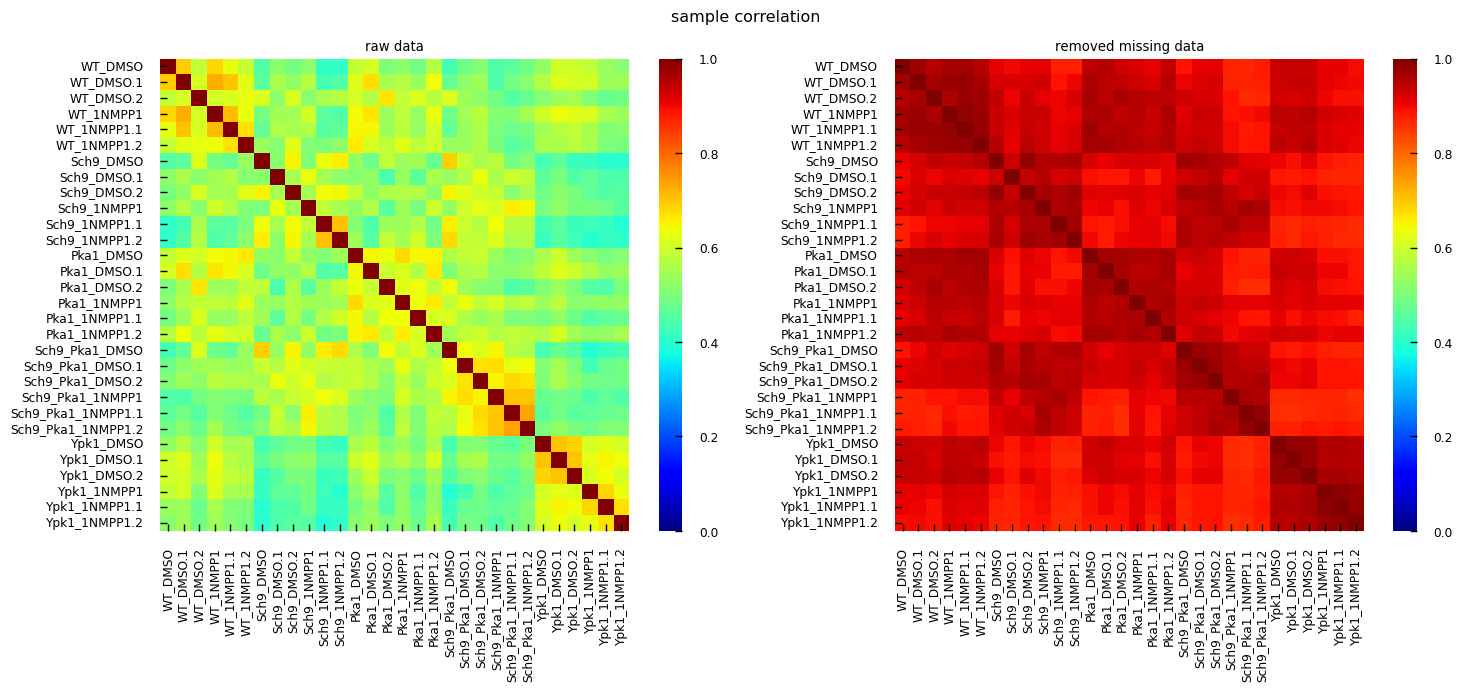

In [10]:
fig,ax = plt.subplots( 1,2,figsize=(15,7))

sns.heatmap(X_ph.corr(),ax=ax[0], cmap='jet' , vmin = 0 , vmax = 1)
ax[0].set_title("raw data")

sns.heatmap(X_ph_positive.corr(), ax= ax[1], cmap='jet' , vmin = 0 , vmax = 1)
ax[1].set_title("removed missing data")

fig.suptitle('sample correlation')
plt.tight_layout()

We see that the replicates of the same mutant strain correlate and the mutant strain has a stronger effect than the treatment (1NMPP1 or DMSO), but removing missing values in this case clearly improves the correlation between treatments! 


For more imputation techniques check : [Scikit-learn imputation](https://scikit-learn.org/stable/modules/impute.html). There is abundant literature and sophisticated methods on missing value imputation. Unfortunately we cannot cover this important subject in this course.

---

Another missing value strategy would be to **impute all zero values with half the minimum of positive values for each peptide (row)**. (half minimum because the values are not missing at random but rather are overepresented by peptides with an average low intensity)

In [11]:
## compute the mimimum among non-0 values:
imput_values = 0.5 * np.min(X_ph[X_ph>0],axis=1)
imput_values.head()

0    3.988691
1    3.444084
2    3.297792
3    2.872687
4    3.081669
dtype: float64

In [12]:
X_ph_imputed=X_ph.copy()

X_ph_imputed[ X_ph_imputed <=0 ] = np.nan ## replacing 0s and negative by NaN, so we can use fillna()

## pd.fillna is great but the version by row has not been implemented (yet, for v1.4.2)
## so we will transpose our dataframe back and forth
X_ph_imputed = X_ph_imputed.transpose().fillna( imput_values , axis = 0 ).transpose()

X_ph_imputed.head()

WT_DMSO  WT_DMSO.1  WT_DMSO.2  WT_1NMPP1  WT_1NMPP1.1  WT_1NMPP1.2  \
0  8.111105   8.139281   8.101774   8.038697     8.081764     8.058197   
1  3.444084   3.444084   3.444084   3.444084     3.444084     3.444084   
2  6.979009   6.954673   6.949864   6.984677     6.940531     6.969075   
3  2.872687   2.872687   2.872687   5.807965     5.745374     5.847605   
4  7.254044   7.258416   7.217928   7.212294     7.219502     6.163339   

   Sch9_DMSO  Sch9_DMSO.1  Sch9_DMSO.2  Sch9_1NMPP1  ...  Sch9_Pka1_DMSO.2  \
0   8.071512     8.165305     8.080783     8.132232  ...          8.111381   
1   3.444084     3.444084     3.444084     6.888168  ...          3.444084   
2   7.067305     7.071589     6.999701     7.135595  ...          6.910873   
3   2.872687     6.212480     6.184184     6.172707  ...          2.872687   
4   3.081669     3.081669     3.081669     7.902286  ...          3.081669   

   Sch9_Pka1_1NMPP1  Sch9_Pka1_1NMPP1.1  Sch9_Pka1_1NMPP1.2  Ypk1_DMSO  \
0          8.061021            8.110272            8.095640   8.011904   
1          3.444084            6.947316            3.444084   3.444084   
2          7.153575            7.181344            7.049465   6.632757   
3          2.872687            2.872687            2.872687   2.872687   
4          8.006840            7.912034            7.923167   3.081669   

   Ypk1_DMSO.1  Ypk1_DMSO.2  Ypk1_1NMPP1  Ypk1_1NMPP1.1  Ypk1_1NMPP1.2  
0     7.977381     7.995326     7.989487       8.002461       8.009906  
1     3.444084     3.444084     3.444084       3.444084       3.444084  
2     6.648691     6.715855     6.623836       6.632217       6.782414  
3     2.872687     5.752769     6.086799       2.872687       2.872687  
4     3.081669     7.679796     7.719625       7.713210       7.778927  

[5 rows x 30 columns]

**Micro exercise** : vizualize the correlation between samples on the data imputed with half the mimimum. Which strategy is preferable in that particular case?

### Making sure columns are the right type <a class="anchor" id="TY-bullet"></a>

In [13]:
df_ph.dtypes

Peptide sequence       object
Phosphosites           object
Standard name          object
WT_DMSO               float64
WT_DMSO.1             float64
WT_DMSO.2             float64
WT_1NMPP1             float64
WT_1NMPP1.1           float64
WT_1NMPP1.2           float64
Sch9_DMSO             float64
Sch9_DMSO.1           float64
Sch9_DMSO.2           float64
Sch9_1NMPP1           float64
Sch9_1NMPP1.1         float64
Sch9_1NMPP1.2         float64
Pka1_DMSO             float64
Pka1_DMSO.1           float64
Pka1_DMSO.2           float64
Pka1_1NMPP1           float64
Pka1_1NMPP1.1         float64
Pka1_1NMPP1.2         float64
Sch9_Pka1_DMSO        float64
Sch9_Pka1_DMSO.1      float64
Sch9_Pka1_DMSO.2      float64
Sch9_Pka1_1NMPP1      float64
Sch9_Pka1_1NMPP1.1    float64
Sch9_Pka1_1NMPP1.2    float64
Ypk1_DMSO             float64
Ypk1_DMSO.1           float64
Ypk1_DMSO.2           float64
Ypk1_1NMPP1           float64
Ypk1_1NMPP1.1         float64
Ypk1_1NMPP1.2         float64
dtype: obj

It is a good idea to check the dtype of you dataframe values and check whether they have the correct type. Here the types are correct, but if you wanted to change them you could use the following syntax:

In [14]:
df_ph["WT_DMSO"] = df_ph["WT_DMSO"].astype('float64')

### One hot encoding of categorical data <a class="anchor" id="OH-bullet"></a>

Certain ML algorithms (linear models, SVMs, NNs) require numerical values. Ordered categorical features (e.g. size = small, medium, large) or features with just two values can just be enumerated (e.g. size = 1,2,3). However, unordered categorical features or factors (e.g. color = blue, gray, pink) need to be turned into orthogonal vectors of 0 and 1, where each index in the vector corresponds to a level of the factor (e.g. blue = (1,0,0), gray = (0,1,0) and pink = (0,0,1). This is the so-called OneHot encoding of categorical features.

For instance, let's consider the following toy dataset with 3 columns : 2 categorical and 1 ordinal.

In [15]:
df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})
df


A  B  C
0  a  b  1
1  b  a  2
2  a  c  3

In [16]:
# method 1 : pd.get_dummies( ... )
pd.get_dummies( df )

C    A_a    A_b    B_a    B_b    B_c
0  1   True  False  False   True  False
1  2  False   True   True  False  False
2  3   True  False  False  False   True

In [17]:
# method 2 : sklearn OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
cat = df[['A','B']] # here we only perform the encoding with columns A and B
ohe = pd.DataFrame(enc.fit_transform(cat).toarray())

ohe.head()

0    1    2    3    4
0  1.0  0.0  0.0  1.0  0.0
1  0.0  1.0  1.0  0.0  0.0
2  1.0  0.0  0.0  0.0  1.0


You can choose to use one or the other depending on your needs, habits, and/or the format of your original data.

Note that there are **as many columns created as factor values**. This can lead to somewhat redundant/perfectly correlated columns (e.g. columns `A_a` and `A_b` are the converse of the one another) which can be detrimental (for instance, linear regressions expect that the covariables are not colinear). 

You can use the `drop_first=True` option of `pd.get_dummies` get rid of these "extra" columns:

In [18]:
pd.get_dummies( df , drop_first=True )

C    A_b    B_b    B_c
0  1  False   True  False
1  2   True  False  False
2  3  False  False   True

<font size="6"> Enough with data processing let's start some real science </font>

## Dimensionality reduction <a class="anchor" id="fourth-bullet"></a>

Dimensionality reduction serves two puposes

 * **Visualization**: reducing the number of dimensions to 2 or 3 allows displaying the whole dataset for visual inspection
 * **Data compression**: some features may be little informative and projecting feature vectors to the principal data manifold allows discarding the uninformative part of the feature space


### Principal Component Analysis (PCA) <a class="anchor" id="PCA-bullet"></a>

As described in the lecture notes, PCA finds the direction in feature space with the largest variance (first principal component), meaning the direction where the data points are most spread out. Then it repeats the same algorithm to find the direction orthogonal to the first principal component (second principal component) with the largest (remaining) variance. The second principal component can only give information about the variance not explained by the first component. Mathematically this boils down to the eigenvalue decomposition or diagonalization of the covariance matrix, where the eigenvalue is the variance of the data along its eigenvector (principal component).

In PCA are looking for the matrix of eigenvalues $\pmb{D}$ and orthogonal basis vectors (eigenvectors) $\pmb{W}$, that satisfies the following relation:

$\pmb{X}^T\pmb{X}=\pmb{W}\pmb{D}\pmb{W}^T$

$\pmb{X}$ must be centered around the mean value of each feature vector (each column in the dataframe has zero empirical mean), so that $\pmb{Q}=\pmb{X}^T\pmb{X}$ is the covariance matrix of your multidimensional data (zero centering is done by the PCA algorithm, so no need to do it yourself).

> Note: algorithms that perfom PCA generally use Singular Value Decomposition (SVD). 

![PCA illustration](../images/PCA.png)

The output of such a process is a set of eigenvectors or PCs (which are a linear combination of your former features) and the variance corresponding to each eigenvector (eigenvalues). The eigenvalues are in decreasiung order to give us their decreasing signficance to explain the overall variance. The Scikit-learn [PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) has, as other scikit classes, two main methods: fit() and transform(). For a data matrix $\pmb{X}$ of size NxM (N data rows, M feature colums) the fit($\pmb{X}$) calculates $\pmb{W}$ (with the M PCs as columns) of $\pmb{X}$ and the transform($\pmb{X}$) method provides the coordinates of the N data vectors in the eigenvector or principal component space by calculating $\pmb{X'}=\pmb{X}\pmb{W}$ (in case of 'whiten'=False).

PCA analysis has a clear mathematical framework and is fast to calculate (compared to t-SNE, for example). It can be easily applied to distributed data and is therefore also attractive for very large datasets. It also serves as a preprocessing step to de-correlate or 'whiten' a data matrix (see Appendix).

### PCA on the phospho peptide dataset

In [28]:
from sklearn.decomposition import PCA
pca = PCA() #create an empty PCA object

pca.fit(X_ph) # calculates variances (eigenvalues)) and principal components (eigenvectors)

x_pca = pca.transform(X_ph) # calculates coordinates of row vectors in X in PC space

## pca.explained_variance_ratio_ contains the fraction of the variance explained by each PCA axis (don't forget the _ at the end) 
pca.explained_variance_ratio_

array([0.5623593 , 0.06653024, 0.04055625, 0.03102832, 0.02457798,
       0.01745948, 0.01585424, 0.01537049, 0.01474057, 0.01322293,
       0.01274278, 0.01240088, 0.01190712, 0.01174396, 0.0116302 ,
       0.01109683, 0.0109096 , 0.01050733, 0.01038572, 0.00983176,
       0.00967841, 0.00936164, 0.00923748, 0.00898549, 0.00871453,
       0.00863738, 0.00815868, 0.0078709 , 0.0073785 , 0.00712102])

Text(0.5, 1.0, 'raw data')

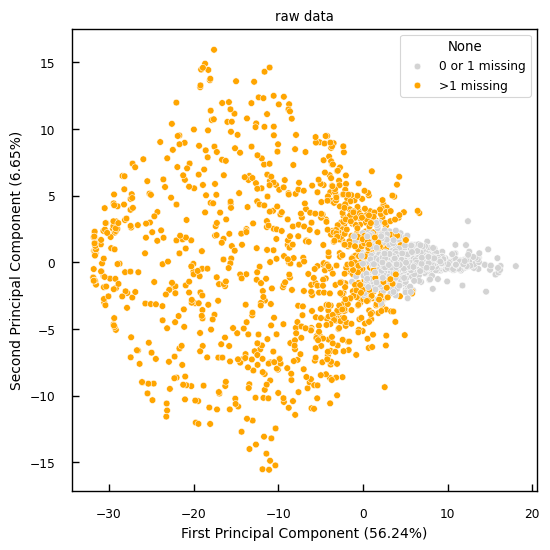

In [31]:
plt.figure(figsize=(6,6))
sns.scatterplot( x = x_pca[:,0] , y = x_pca[:,1] , 
                hue = (nr_missing>1).map({False:'0 or 1 missing',True:'>1 missing'}),
                palette = ['lightgrey','orange'] )
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("raw data")

We see that the first two principal components explain more than 60% of the total variance. There is a large scatter in the points to the right in the plot. This is due to the missing values (orange points). Discarding of the peptides with missing values removes this variance.

### PCA on the phospho peptide dataset without missing values

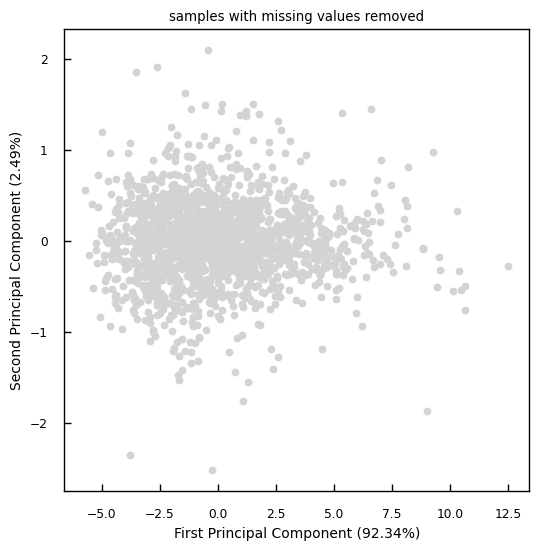

In [23]:
pca = PCA() #create an empty PCA object

pca.fit(X_ph_positive) # calcultes variances (eigenvalues)) and principal components (eigenvectors)

x_pca = pca.transform(X_ph_positive) # calculates coordinates of row vectors in X in PC space

plt.figure(figsize=(6,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c='lightgrey')
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("samples with missing values removed")
plt.show()

Now the **first PC explains 92% of the variance, i.e. the data is almost 1-dimensional!** 

What is going on? Inspection of the data shows that the peptides (rows) have different total intensities and the first PC just reflects this intensity difference.

Text(0, 0.5, 'peptide intensity')

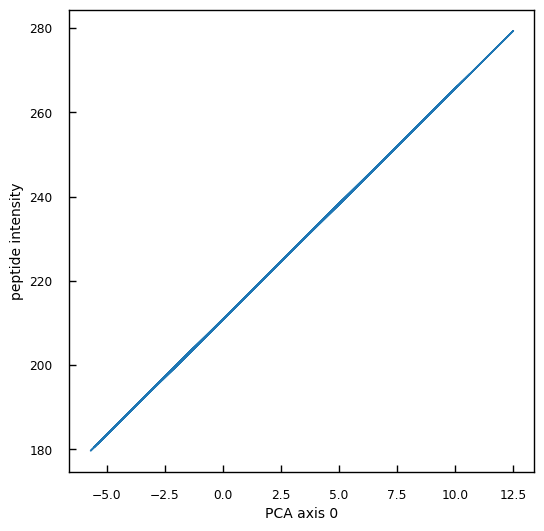

In [26]:
pept_intens = X_ph_positive.sum(axis=1)
plt.plot( x_pca[:,0] , pept_intens)
plt.xlabel( 'PCA axis 0' )
plt.ylabel( 'peptide intensity' )

In this study we are not interested in the total peptide intensity, but only in the relative intensities between treatments (columns). Therefore we can normailze the peptide rows and make sure that each row has a total intensity of 1.

Remark: the PCA class has a 'withen' parameter (see Appendix). However, it does not remove the intensity dependency here and and does not change the plot (try it yourself!).

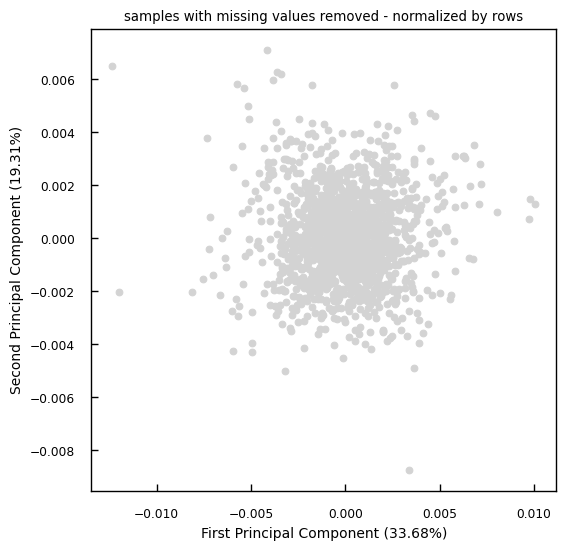

In [32]:
pca = PCA() #create an empty PCA object

X_ph_norm = X_ph_positive.div(pept_intens, axis=0)

pca.fit(X_ph_norm) # calcultes variances (eigenvalues)) and principal components (eigenvectors)
x_pca = pca.transform(X_ph_norm) # calculates coordinates of row vectors in X in PC space


plt.scatter(x_pca[:,0],x_pca[:,1],c='lightgrey')
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.title("samples with missing values removed - normalized by rows")
plt.show()

We see that the variance along the first PC is now reduced to 34%. Now the PCA plot does not tell us much about the data. We can get more information by plotting the directions that correspond to the individual treatments. We can get the treatment directions via pca.components_, which is our MxM matrix $\pmb{W}^T$ (M = number of columns, features or treatments) where each row holds the PC coordinates in feature space and each column the treatment coordinates in PC space. The rows of pca.components_ are ordered by decreasing variance. 

The visualization of this matrix also reveals that the components of first 5 PC show good aggreement between replicates, and afterwards the PC componenents become noisy.

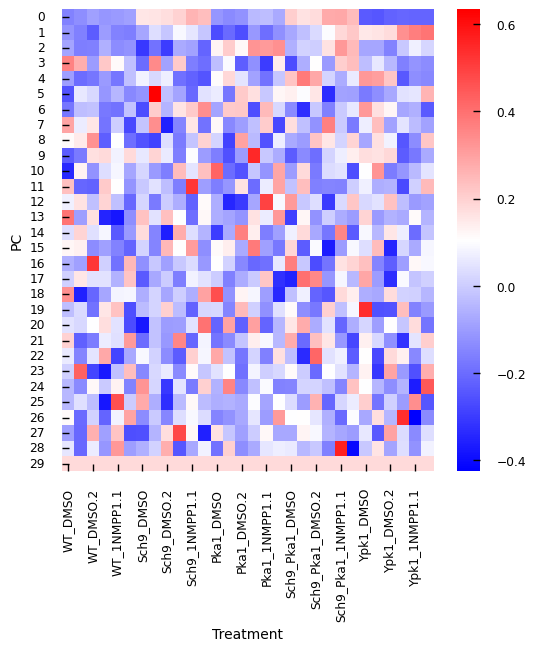

In [33]:
df_comp = pd.DataFrame(pca.components_,columns=X_ph.columns)
sns.heatmap(df_comp,cmap='bwr')
plt.xlabel("Treatment")
plt.ylabel("PC")
plt.show()

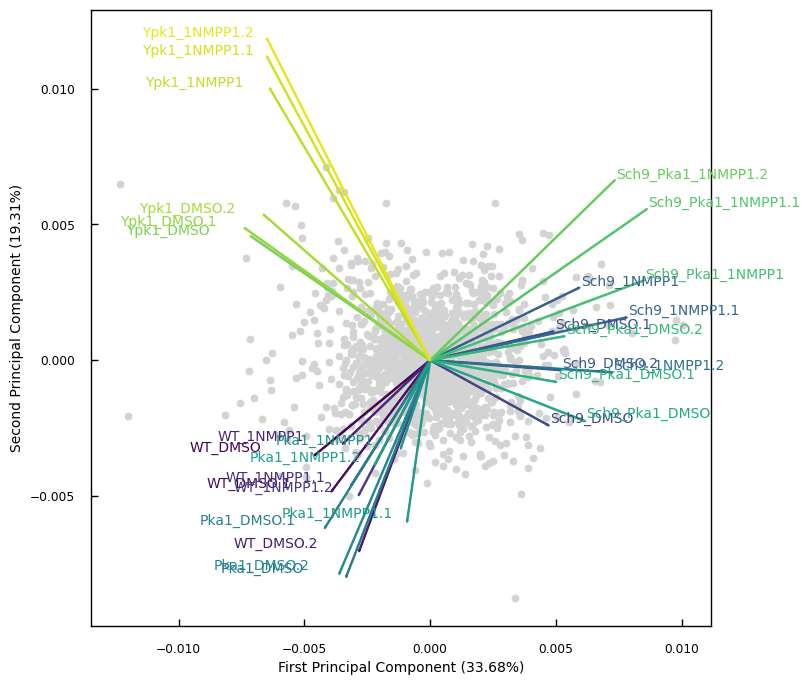

In [34]:
plt.figure(figsize=(8,8))
plt.scatter(x_pca[:,0],x_pca[:,1],c='lightgrey')
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 0.03

# projections of the original features
cmap = colormaps.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, X_ph.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    

plt.show()


We see now that the Ypk1 mutants cluster together and 1NMPP1 treatments are distinct from DMSO control. Pka1 clusters with the WT strains and there is less difference between treatment and control. Sch9 and Sch9_Pka1 are similar indicating the Sch9 mutant effect is stronger than the Pka1. Overal the mutant effect seems stronger than the treatment effect.

### PCA on the immunogenicity dataset <a class="anchor" id="PCAi-bullet"></a>

The second dataset we would like to use is taken from a publication by [Stronen et al., Science, 2016](https://science.sciencemag.org/content/352/6291/1337) in the field of cancer immunology. It measured the immunogenic potential of peptides carrying somatic mutations by testing whether they induce a CD8+ T cell response in a healthy donor. 

There are 3 different outcomes of the "CD8+ T cell response induced in healthy donor: Tested/Observed” feature: 
 * 11 positive (YES/YES), 
 * 46 negative (YES/NO), 
 * 977 unclear (NA). 
 
 The table gives various predictors of immunogenicity such as predicted HLA binding affinity for WT and mutant peptides, predicted HLA binding stability, predicted proteome cleavage compatibility, RNA-seq expression of the mutated gene, RNA-seq read coverage of the mutation.

In [35]:
df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],"na")
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = "ne"
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = "po"

df_im.loc[response=="po",'Mutant peptide'] += "*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]].copy()

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im.rename(columns = d, inplace = True) # rename the columns

# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im.RNA_expr = np.log10(X_im.RNA_expr)
X_im.WT_affin = np.log10(X_im.WT_affin)
X_im.MUT_affin = np.log10(X_im.MUT_affin)


X_im.set_index(df_im['Mutant peptide'], inplace=True)

X_im_num = X_im.copy()
X_im['Response'] = response

X_im.head()


MUT_pos  WT_affin  MUT_affin  WT_cleav  MUT_cleav  \
Mutant peptide                                                      
STAFDFLAV             4  2.176091   2.559907      0.84       0.89   
SQSPSSFSM             9  3.561936   2.921686      0.74       0.97   
KIQANALPL             4  2.376577   2.770115      0.97       0.95   
YASSYIILA             6  1.934498   1.698970      0.19       0.54   
FALGNVISA             1  3.525304   2.376577      0.87       0.76   

                WT_stability  MUT_stability  WT_read_perc  RNA_expr Response  
Mutant peptide                                                                
STAFDFLAV              0.433          0.407          47.6  5.503815       ne  
SQSPSSFSM              0.468          0.540          16.9  3.124964       na  
KIQANALPL              0.667          0.559          10.1  1.042831       na  
YASSYIILA              0.564          0.689          64.0  4.849064       na  
FALGNVISA              0.459          0.697          50.8  5.674780       ne

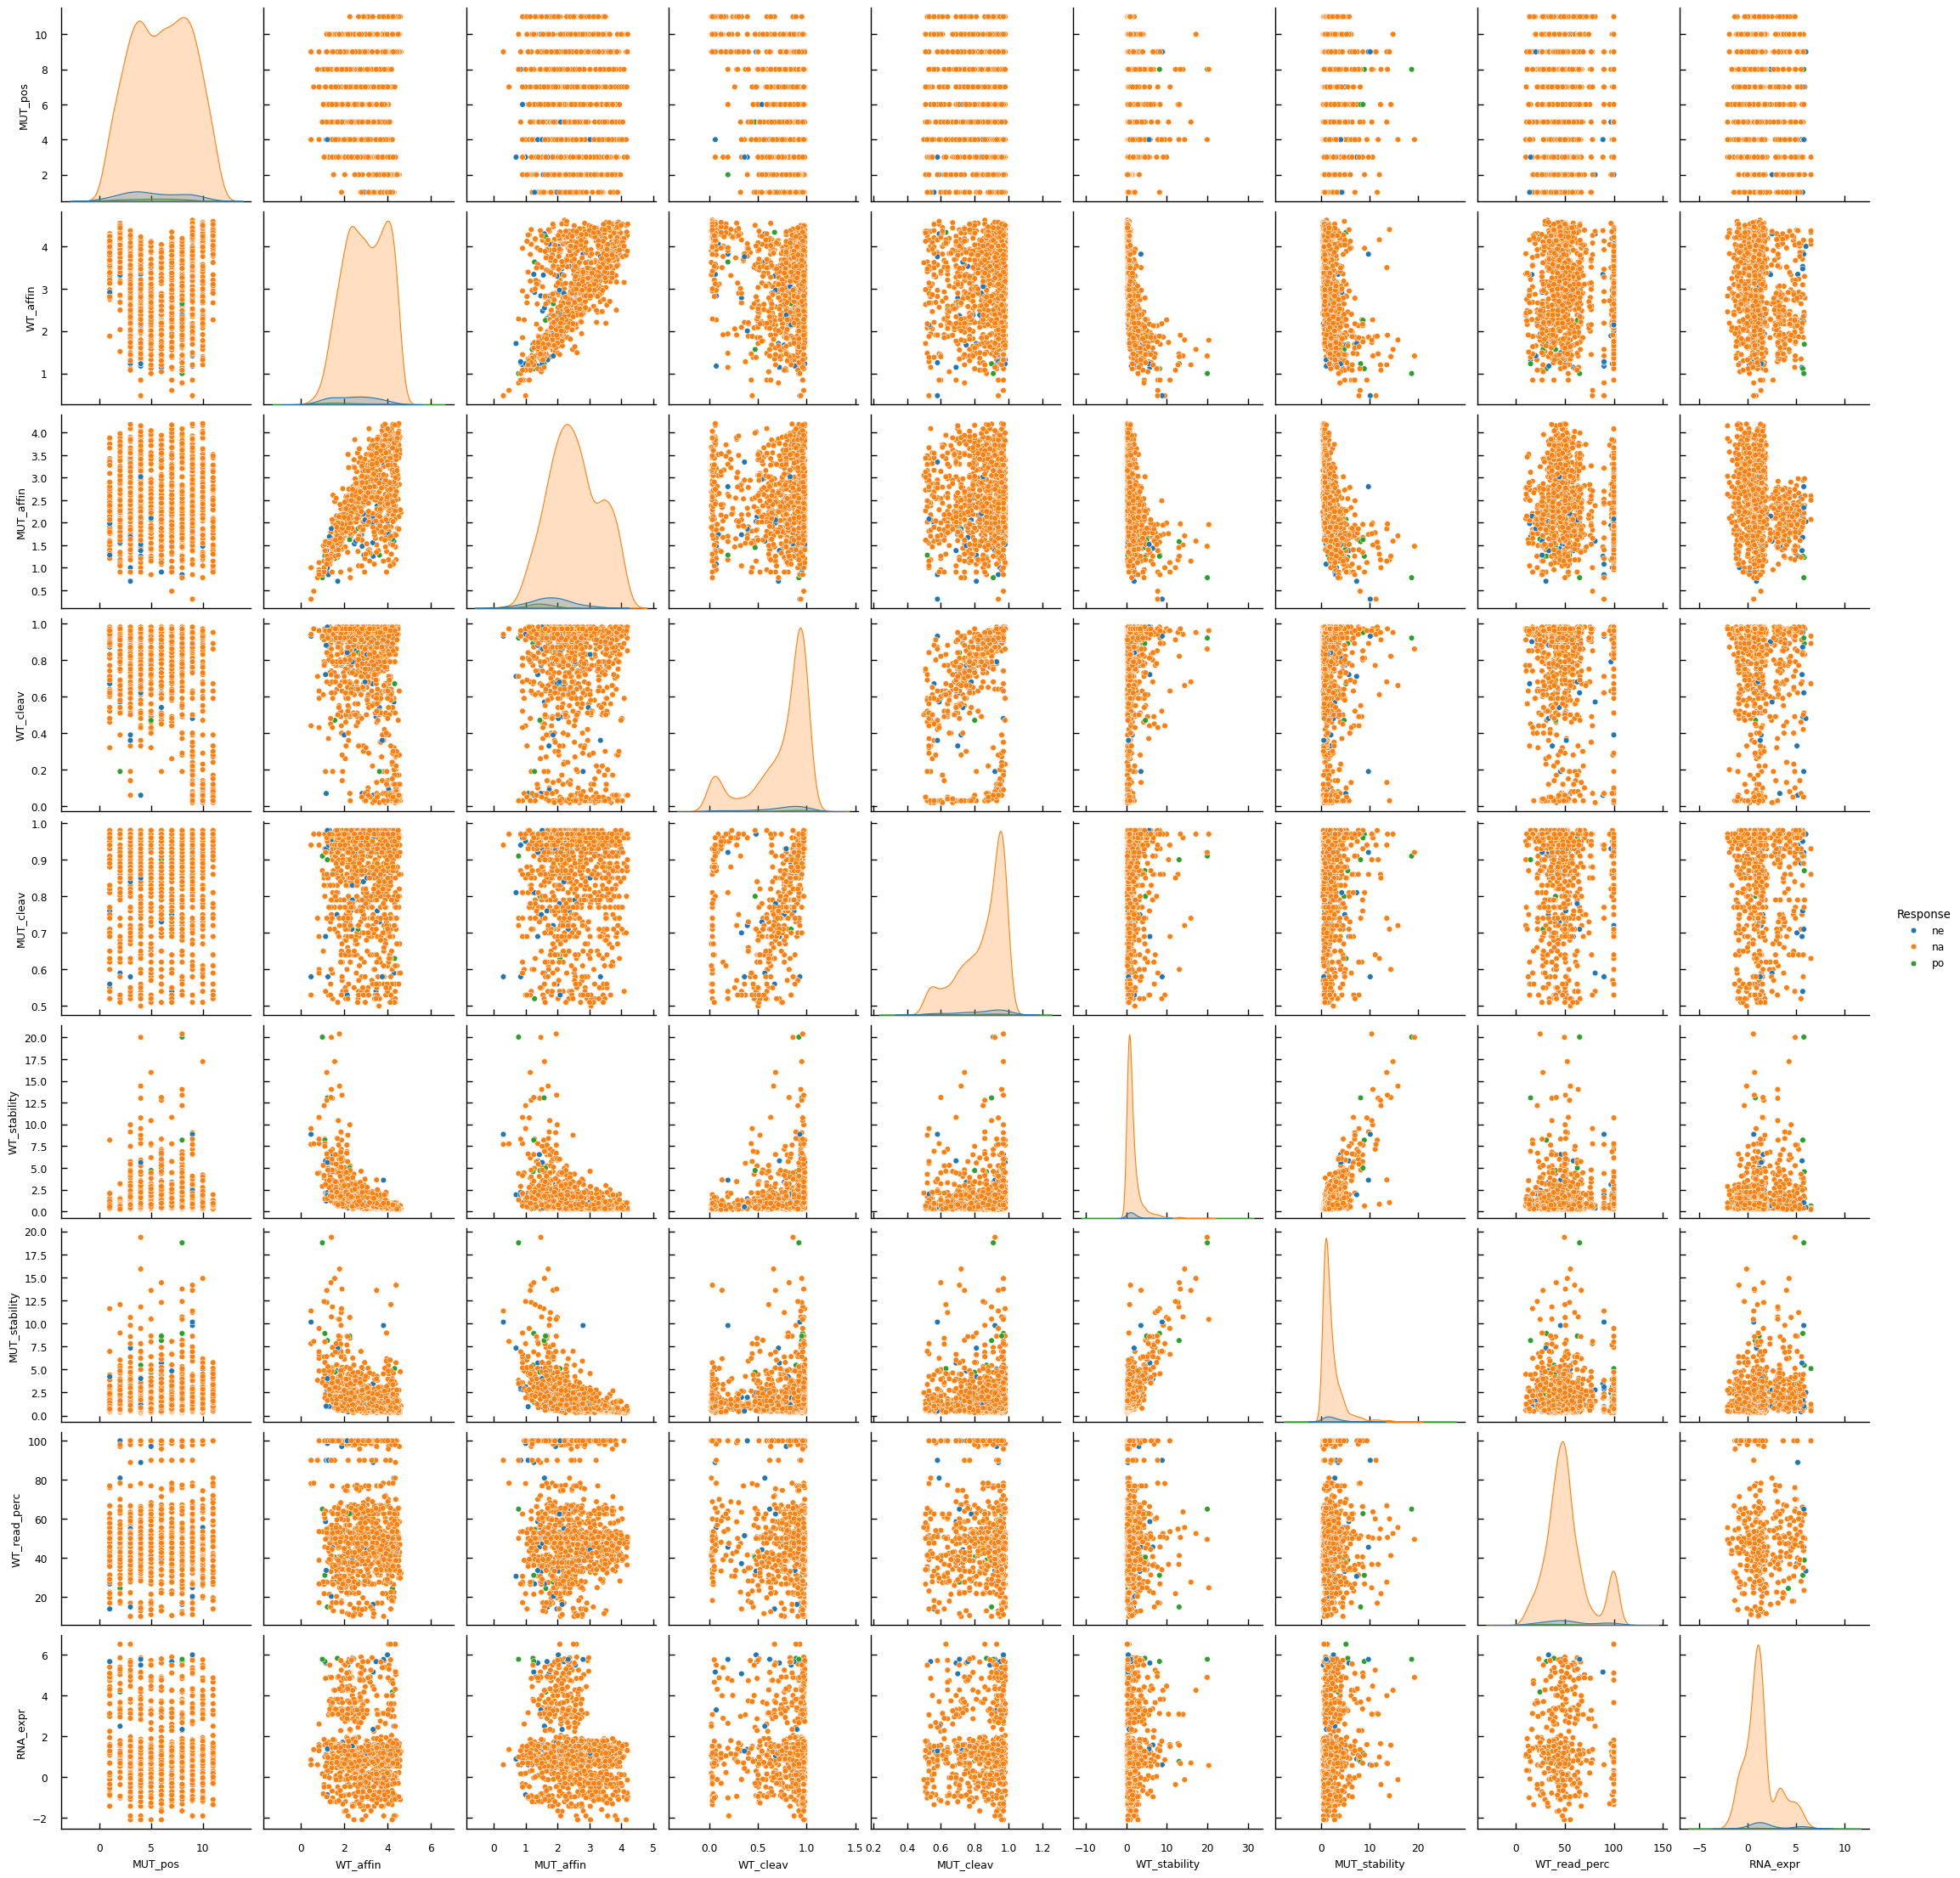

In [36]:
## here the index show some duplicates which can create errors, so for convenience's sake we reset the index for some function call
sns.set_context("paper", rc={"axes.labelsize":9})
sns.pairplot(X_im.reset_index(), hue="Response")

We see that the features have different scale and a PCA analysis without rescaling the features to a similar range would distort the PCA plots and not reveal much useful information (try it out!). Therefore we transform our features into z-scores using the python StandardScaler class before we perform PCA.

Text(0, 0.5, '% variance')

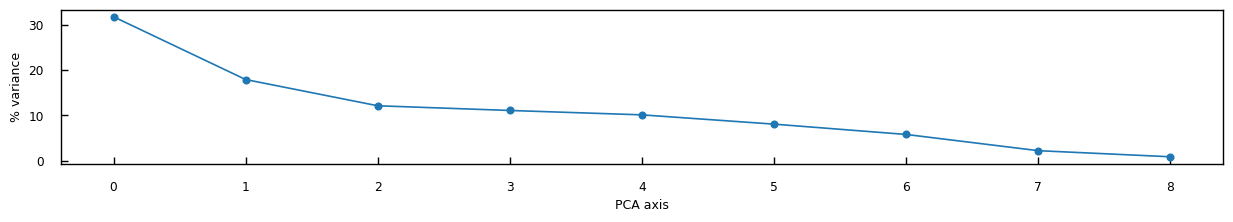

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

color_dict={'ne':'blue', 'po':'red', 'na': 'gray'}
cols_im = X_im.Response.map( color_dict ).to_list()

#scaling 
scaler = StandardScaler()
X_im_scaled = scaler.fit_transform(X_im_num)

# PCA
pca = PCA() #create an empty PCA object
x_pca = pca.fit_transform(X_im_scaled) # calculates coordinates of row vectors in X in PC space

fig, ax = plt.subplots(figsize=(15,2))
ax.plot( pca.explained_variance_ratio_ *100 , marker='o')
ax.set_xlabel("PCA axis")
ax.set_ylabel("% variance")

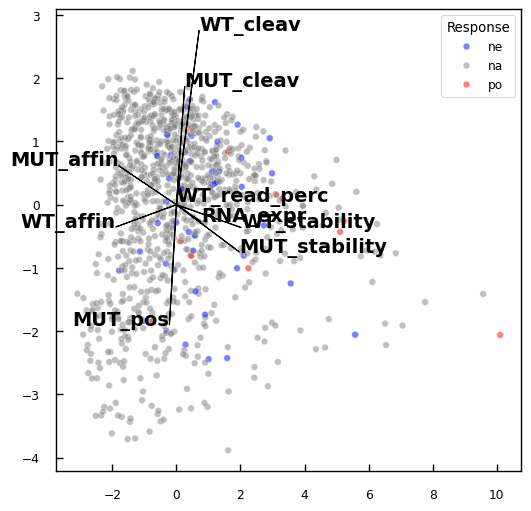

In [42]:


sns.scatterplot(x=x_pca[:,0],y=x_pca[:,1],
                hue=X_im['Response'] , palette = { 'ne':'blue', 'po':'red', 'na': 'gray' } , alpha = 0.5)
ax.set_xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))


# projections of the original features on the first 2 axis of the PCA space
feature_vectors = pca.components_.T[:,[0,1]]


cmap = colormaps.get_cmap('viridis')
n = feature_vectors.shape[0]

# enumerate over the rows of feature_vectors to create arrows
for i, v in enumerate(feature_vectors): 
    arrow_scaling = 4
    
    plt.arrow(0, 0, arrow_scaling* v[0], arrow_scaling * v[1], 
              head_width=10*10**-5, head_length=10*10**-5, width=5*10**-5,
              color="black")

    ha = 'left' # we want to change the horizontal alignment depending on the sign of PC0
    if v[0] < 0:
        ha = 'right'
    plt.text(v[0]*arrow_scaling, v[1]*arrow_scaling, 
             X_im_num.columns[i], 
            color="black", 
             fontsize=14, weight='bold',
             ha = ha)
    


We see that the CD8 positive mutated peptides (red dots) are predominantly found in the right half of the plot. The feature vectors that point along the direction of the red dots axis are MUT_affinity and MUT/WT_stability.

### t-SNE <a class="anchor" id="tsne-bullet"></a>

t-SNE (t-distributed Stochastic Neighborhood Embedding) is a dimensionality reduction algorithm introduced by [Maaten and Hinton, 2008](https://www.jmlr.org/papers/v9/vandermaaten08a.html). Unlike PCA or ICA it is not a linear method. 

#### A little bit of mathematics:

t-SNE assumes that the in the high dimensional data points are normally distributed with variances $\sigma_i^2$. Namely distance between points $\bf{x_i}$ and $\bf{x_j}$ is represented as: 

$p_{i|j}=\frac{exp(-||x_{i}-x_{j}||^2/(2\sigma_i^2))}{\sum_{k\neq_i}exp(-||x_{i}-x_{k}||^2/(2\sigma_i^2))}$

For the representation in the low dimensional space, t-SNE uses a heavy tailed t-distribution, which does not penalize large distances much. This gives us the flexibility needed to stretch the high dimensional data onto a low dimensional space and will allow better visual separability of the clusters. 

$q_{i|j}=\frac{(1+||y_{i}-y_{j}||^2)^{-1}}{\sum_{k\neq_i}(1+||y_{i}-y_{k}||^2)^{-1}}$

t-SNE forces these two distributions to be as close as possible for a "good" representation. As the similarity measure between the $P_i$ and $Q_i$ distributions they use the Kullback-Leibler divergence:

$C=\sum_{i}KL(P_i||Q_i)=\sum_{i}\sum_{j}p_{i|j}log(\frac{p_{i|j}}{q_{i|j}})$

If the $\sigma_i^2$ values are known t-SNE finds a local minimum in $C({y_i})$ by a gradient descent algorithm. In order to fix the $\sigma_i^2$ values t-SNE uses the 'perplexity' parameter:

$Perp(x_i)=2^{-\sum_{j}p_{j|i}log(p_{j|i})}$


![tSNA illustration](../images/tsne.png)


The higher the `perplexity`, the higher the entropy and the larger $\sigma_i$. `perplexity` therefore reflects the  number of neighbors to consider for the calculation of $p_{i|j}$. A constant perplexity assures that each point will consider approximately the same number of neighbours.

Finally, t-SNE does neither conserve distances nor densities : it is trully a visualization technique and should not be used with other clustering techniques that require distance or density conservation between full and reduced space.

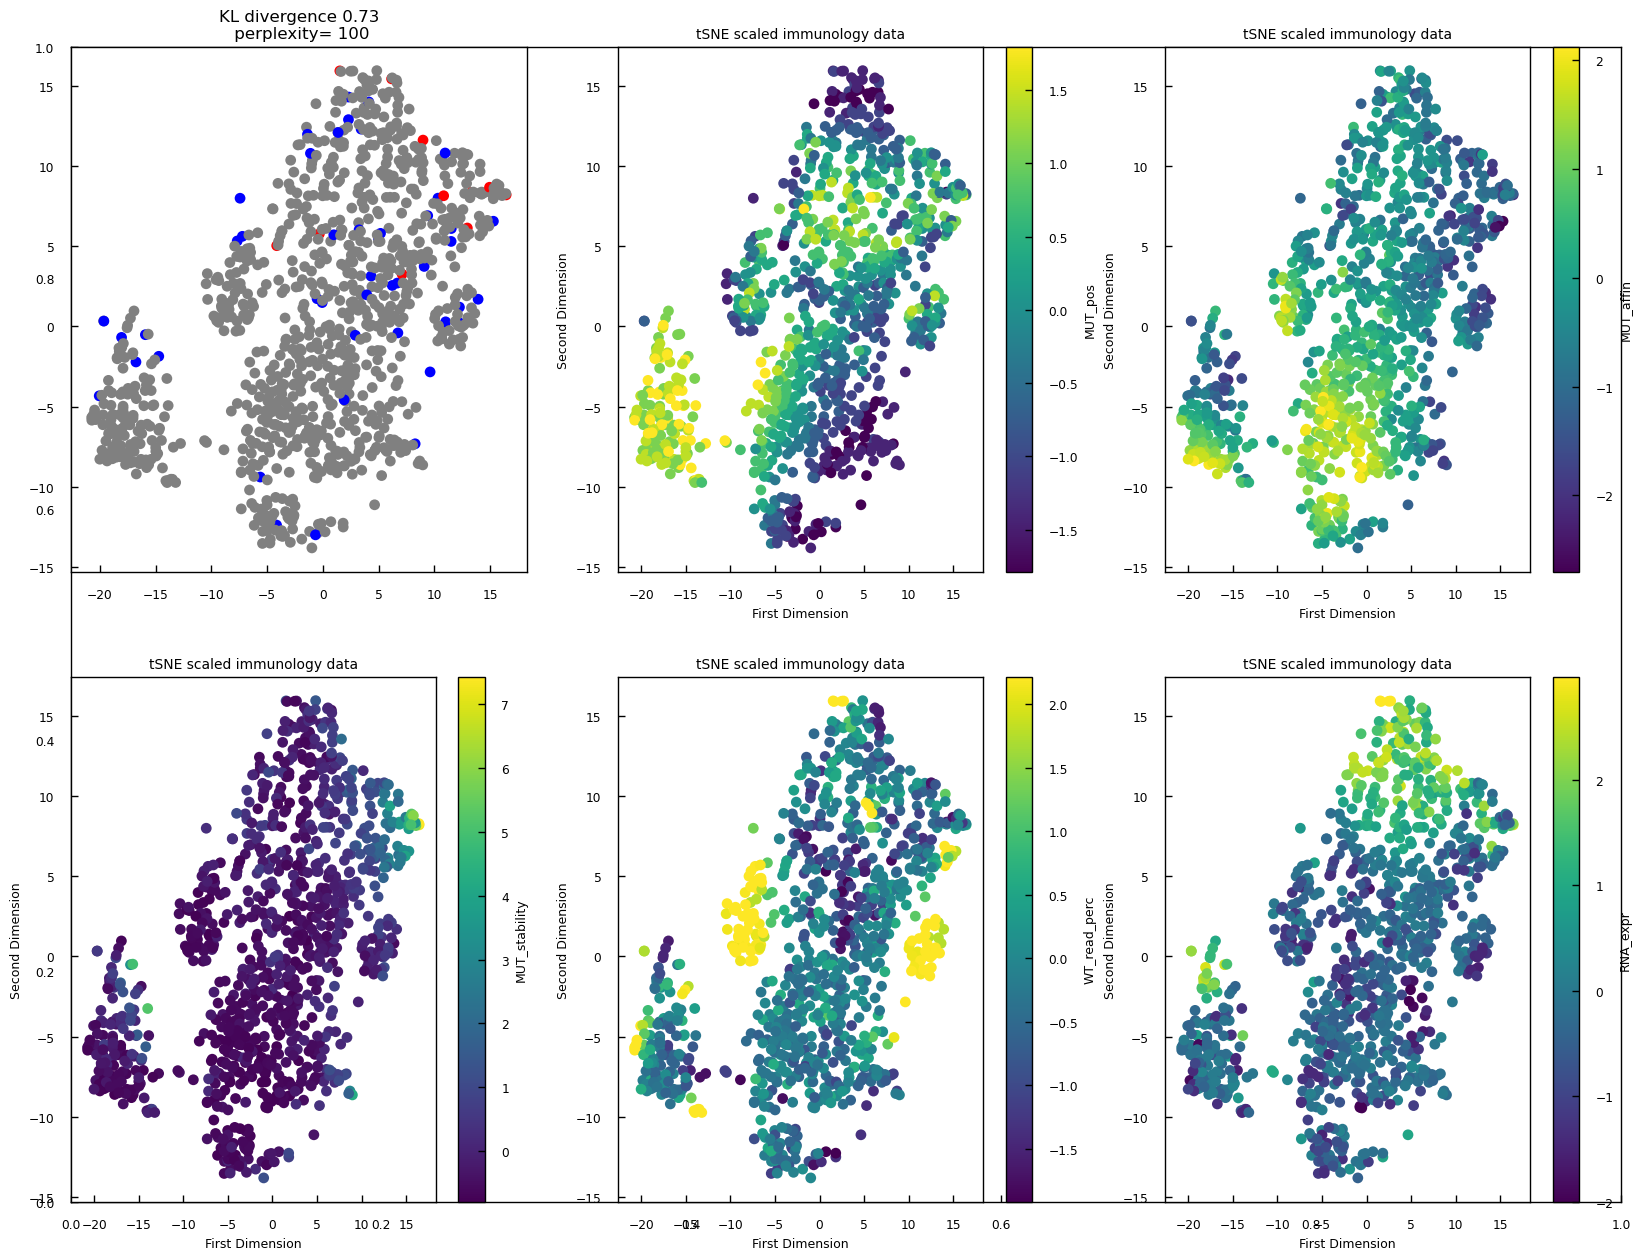

In [43]:
from sklearn.manifold import TSNE

perplexity = 100
tsne=TSNE(n_components=2,perplexity=perplexity).fit(X_im_scaled)#create the T-SNE object and fit the data

plt.subplots(figsize=(20,15))

plt.subplot(2,3,1)
X_embedded = tsne.embedding_#project the data to the new manifold using the fitted function found before
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=cols_im, s=60, lw=0)
plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,perplexity),fontsize=12)

j = 2
for cl in ['MUT_pos','MUT_affin','MUT_stability','WT_read_perc','RNA_expr']:
    plt.subplot(2,3,j)
    i = np.where(X_im.columns==cl)[0][0]
    X_embedded = tsne.embedding_ #project the data to the new manifold using the fitted function found before
    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=X_im_scaled[:,i], s=60, lw=0,cmap='viridis')
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
    cb = plt.colorbar(sc)
    cb.set_label(cl)
    plt.title('tSNE scaled immunology data',fontsize=10)
    j += 1

plt.show()


Making a direct correspondance between the new and the former basis is not straight forward, since the transformation is non-linear and dependent on the position in the reduced space. Yet to get a feeling about what the features represent you can color code the feature values and see how they change in the transformed space.

We see that some clusters are formed by distinct feature values. For example one cluster is formed by peptides with 'WT_read_perc' of 100. Features with descrete values can split up the t-SNE plot into seperate parts.

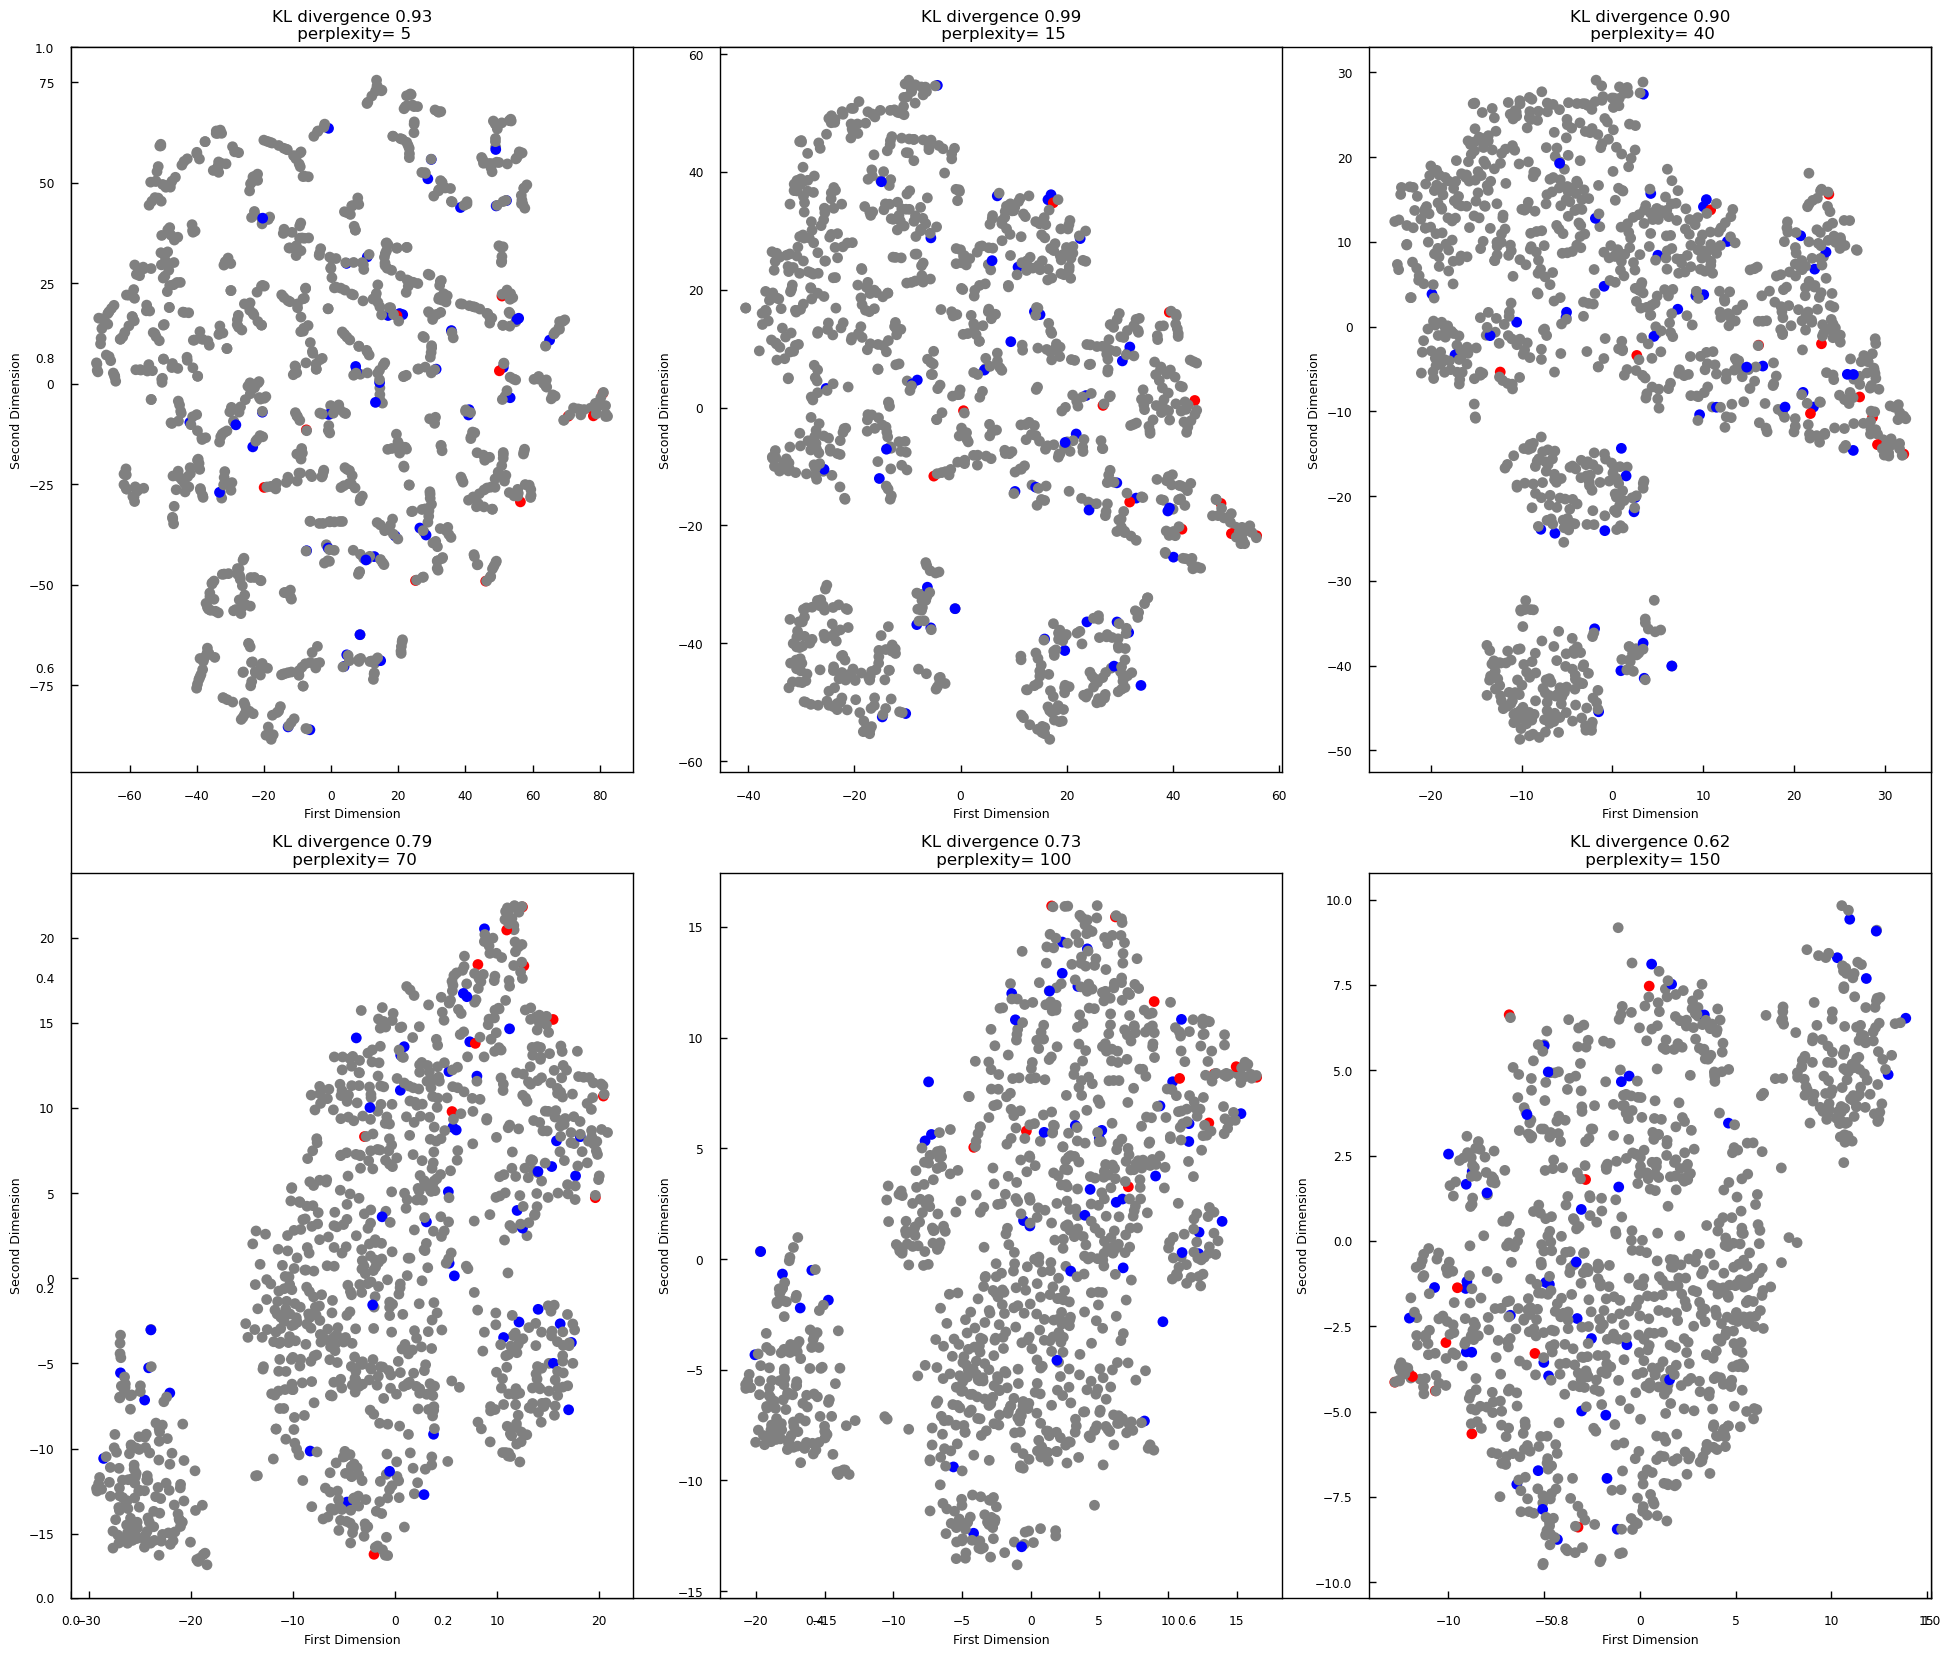

In [44]:
p=[5,15,40,70,100,150] #perplexity parameters to test
plt.subplots(figsize=(20,17))
for j in range(len(p)):
    plt.subplot(2,3,j+1)
    tsne=TSNE(n_components=2,perplexity=p[j],init='pca',learning_rate='auto').fit(X_im_scaled)#create the T-SNE object and fit the data

    X_embedded = tsne.embedding_#project the data to the new manifold using the fitted function found before
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=cols_im, s=60, lw=0)
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
    plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,p[j]),fontsize=12)
plt.tight_layout()
plt.show()

You can also see that the perplexity parameter determines the topology of the results. It is your guess to pick a perplexity parameter that gives the best representation of your data. For more details I highly encourage everybody to take a look at this [article](https://distill.pub/2016/misread-tsne/)

[Back to ToC](#toc)

## Exercise: PCA <a id="exo-pca"></a>

**Another dataset : AML**

In the following dataset from [Tyner et al. 2018](https://doi.org/10.1038/s41586-018-0623-z) we have the expression level of some genes from some different Acute Myeloid Leukaemia (AML) tumors as well as how they respond to treatment (AUC value). 

Between those different tumors there are probably different mutations occuring in different genes.

In [45]:
df_aml=pd.read_excel('../data/gene_drug_sens.xlsx')
df_aml.head()

sample Disease_type                  ELN2017 Cytogenetics    Mclust  \
0  12-00023       Denovo             Intermediate          NaN  Cluster1   
1  12-00051       Denovo  FavorableOrIntermediate          NaN  Cluster2   
2  13-00118      Relapse                Favorable          NaN  Cluster1   
3  13-00149        Other             Intermediate          NaN  Cluster1   
4  13-00160  Transformed             Intermediate          NaN  Cluster1   

          auc  FLT3_ITD      NPM1    DNMT3A      CD86  ...     ADAP2  \
0  257.569985  negative  negative       NaN -1.120073  ... -1.001751   
1  168.267467  positive  positive       NaN  2.498957  ... -0.933841   
2  271.034652  negative  positive  positive  0.176687  ... -0.185127   
3  286.109498  negative  negative  negative  0.918236  ... -0.333728   
4  261.794860  negative  negative  negative -1.004299  ...  0.564804   

     B3GNT2  RP11-196G18.24      TLR2    MIR223   RAB43P1      GYPC  HSD17B13  \
0  1.556003       -1.608982  0.751515  0.987769  0.232332  0.981147 -2.021119   
1 -0.189892        0.313041  2.097701 -1.627445 -0.961402 -0.523684  0.255906   
2  0.235198       -1.389968  0.007096  1.291810 -0.504791  0.813038 -0.741312   
3  0.038227       -0.187054 -0.376509  0.826023  0.847269 -0.466044  0.374157   
4 -0.835560       -0.566891  0.546441 -0.371254  1.609191  0.220240 -2.180800   

    HNRNPA1     NAPSB  
0 -1.185687 -0.710025  
1  0.885343  0.900553  
2 -1.180863 -2.541507  
3  0.585562 -0.747859  
4  1.076900  0.411095  

[5 rows x 26 columns]

In [46]:
## let's keep only the expression data as well as the response to treatments (auc)
X_aml=df_aml[df_aml.columns[9:]]
X_aml.head()

CD86    FAM49A      ERMN      CHD5  RP11-333E13.2    KLHDC3      HNMT  \
0 -1.120073 -0.148654 -1.579624 -0.756073       0.471452  1.068268 -0.157964   
1  2.498957 -1.015880 -0.859471 -0.555560      -0.142550 -0.161521  2.279642   
2  0.176687 -0.490400 -0.611194 -0.443875       0.876031 -0.147330  0.112438   
3  0.918236  0.377131 -0.410336 -0.033461      -0.014791  1.218267  1.122505   
4 -1.004299 -0.826399  0.995739 -1.426430      -0.053345  0.585897 -0.876732   

      ADAP2    B3GNT2  RP11-196G18.24      TLR2    MIR223   RAB43P1      GYPC  \
0 -1.001751  1.556003       -1.608982  0.751515  0.987769  0.232332  0.981147   
1 -0.933841 -0.189892        0.313041  2.097701 -1.627445 -0.961402 -0.523684   
2 -0.185127  0.235198       -1.389968  0.007096  1.291810 -0.504791  0.813038   
3 -0.333728  0.038227       -0.187054 -0.376509  0.826023  0.847269 -0.466044   
4  0.564804 -0.835560       -0.566891  0.546441 -0.371254  1.609191  0.220240   

   HSD17B13   HNRNPA1     NAPSB  
0 -2.021119 -1.185687 -0.710025  
1  0.255906  0.885343  0.900553  
2 -0.741312 -1.180863 -2.541507  
3  0.374157  0.585562 -0.747859  
4 -2.180800  1.076900  0.411095

In [47]:
# you access the AUC using 
df_aml.auc

0     257.569985
1     168.267467
2     271.034652
3     286.109498
4     261.794860
         ...    
85    135.218527
86    278.970613
87    124.302935
88    174.745142
89    259.485443
Name: auc, Length: 90, dtype: float64

In [ ]:
## WARNING : doing this with all columns takes a couple of minutes
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set(font_scale = 2)
sns.pairplot(df_aml.loc[:, ['auc'] + list(X_aml.columns)[:5]],
             hue="auc")

You can presume that the missing values and data normalization for the gene expression have already been handled.

Perfom a pca on the gene expressions. Choose an interesting number of dimension and interpret the plot : 

 * What does the first component stand for? 
 * What are driving genes behind the first components? 
 
 
**If you have the time:** use other dimensionality reduction techniques such as t-SNE. What do you think?

You can look up the solution by uncommenting andexecution the following line:

In [ ]:
# %load solutions/solution_01_pca.py

# Appendix <a class="anchor" id="appendix-bullet"></a>

## 'Whiten' a data matrix <a class="anchor" id="whiten-bullet"></a>

'Whitening' is a process to reduce correlations between columns in a $NxM$ data matrix $\pmb{X}$ ($N$ samples and $M$ features). It uses PCA to transform $\pmb{X}$ into $\pmb{X'}$ with $\pmb{X'}^T\pmb{X'}=\pmb{\mathbb{1}}$. The process consists of 2 steps:

<ol>
<li>Zero centering around column means: $x_{ij}=x_{ij}-\frac{1}{N}\sum_{k=1}^{N}x_{kj}$</li>
<li>Rotation to PC basis and scaling: $\pmb{X'}=\pmb{X}\pmb{W}\pmb{D^{-\frac{1}{2}}}$, where $\pmb{W}$ is the matrix containing the PC's and D a diagonal matrix containing the variances. This transformation projects on the PC basis vectors and devides by the standard deviations.</li>
</ol>



## UMAP <a class="anchor" id="umap-bullet"></a>

t-SNE has some disadvantages:

<ol>
<li>Speed. t-SNE computations takes a long time for large datasets</li>
<li>Dimensions. t-SNE is not applicable for more than 2-3 dimensions</li>
<li>Global Structure: t-SNE preserves local but not global structure</li>
</ol>

There comes UMAP ([McInnes et al.,arxiv, 2018](https://arxiv.org/abs/1802.03426)), which you probably know from single cell RNA-seq papers. It is similar to t-SNE, but differs in some important details, which make it faster, applicable to more than 2 dimensions and preserve the global structure better. Here is how it works:

UMAP assumes a exponential weight between the high dimensional data points: 

$\mu_{ij}=e^{-\frac{d(x_{i},x_{j})-\rho_i}{\sigma_i}}$

$\rho_i$ is the distance $d(x_{i},x_{k})$ of $x_{i}$ to its nearest neighbor $x_{k}$. Let $NN(i,n)$ be the set of $n$ nearest neighbors of $x_i$. $sigma_i$ is chosen such that $\sum_{k \in NN(i,n)}\mu_{ik} = log_2(n)$. In contrast to t-SNE the weights are not normalized, which saves computation time.

Next the weights $mu_{ij}$ are turned into a weighted adjacency matrix and spectral clustering is used to find an initial embedding of the data points in the low dimensional space.

For the representation in the low dimensional space, UMAP uses a heavy tailed weight:

$\nu_{ij} = (1 + a(|x_i − x_j|_2^2)^b)^{−1}$

UMAP determines the parameters $a$ and $b$ by a least square fitting procedure. As a similarity measure between the $\mu_{ij}$ and $\nu_{ij}$ distributions it uses:

$C=-\sum_{i}\sum_{j}[\mu_{ij}log(\nu_{ij}) + (1-\mu_{ij})log(1-\nu_{ij})]$

UMAP uses stochastic gradient descent algorithm to minimize $C$. The spectrum clustering initialisation as well as the second term in $C$ are supposed to provide a better embedding for distant clusters compared to t-SNE.

UMAP implements an efficient nearest neighbor search and has an overall complexity of $O(N^{1.14})$.

The main input parameters for UMAP are

<ol>
<li>'n_components': dimension of the embedding</li>
<li>'n_neighbors': numer of nearest neigbors to consider (corresponds to $n$ in the text)</li>
<li>'min_dist': points in embedded space need to be separeted by a distance of at least 'min_dist'</li>
<li>'metric': metric to be used for measuring distances (corresponds to $d(x,y)$ in the text)</li>
</ol>

Further information and tutorials you can find un the [UMAP page](https://umap-learn.readthedocs.io/en/latest/index.html).

In [ ]:
## you'll likely have to install the umap library:
#!conda install -y -c conda-forge umap-learn

In [40]:
import umap.umap_ as umap

nn=[2,5,10,30,60,100] #n_neighbors parameters to test
plt.subplots(figsize=(20,17))
for j in range(len(nn)):
    plt.subplot(2,3,j+1)
    umaper = umap.UMAP(n_components=2,n_neighbors=nn[j])
    x_umap = umaper.fit_transform(X_im_scaled)

    plt.scatter(x_umap[:, 0], x_umap[:, 1], color=cols_im, s=60, lw=0)
    plt.title('n_neighbors = {0}'.format(nn[j]),fontsize=12)
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
plt.tight_layout()
plt.show()

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

### Independent Component Analysis <a class="anchor" id="ICA-bullet"></a>

Independent Component Analysis (ICA) comes from the field of signal processing, where it was developped to deconvolve an additive mixture of signals into the source components. Mixtures tend to be gaussian and individual sources non-gaussian and PCA will fail ro recover the sources. In ICA we will not look for directions with the largest variance as in PCA, but for directions with the most non-gaussian distributions. This can also be an informative approach for biological data, where the non-gaussian signal often correspond to informative feature combinations. Also the directions found by ICA do not need to be orthogonal allowing more fexibility in the source decomposition.

In ICA we look for independent components (IC) of a $N$x$M$ data matrix $\pmb{X}$, where the ICs are represented as rows of a $M$x$M$ matrix $\pmb{W}$. ICA looks for an IC basis $\pmb{W}$ such that the columns $\pmb{S}_j$ of the $N$x$M$ source matrix $\pmb{S}=\pmb{X}\pmb{W}^T$ are as non-Gaussian as possible i.e. they maximize a function $F(\pmb{S}_i)$ that is the larger the more $S_{ij}, i=1..N$ deviate from a Gaussian distribution. Before finding the independent components, the data matrix $\pmb{X}$ is usually 'whitened' (see Appendix). 

sklearn provides the [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA.transform) algorithm for ICA decomposition (see [Hyvärinen & Oja, Neural Networks, 2000](https://www.sciencedirect.com/science/article/abs/pii/S0893608000000265?via%3Dihub)). It provides fit($\pmb{X}$) and transform($\pmb{X}$) methods. fit() calculates the IC matrix $\pmb{W}$ (stored in FastICA.components_), the whithening mean $m=\frac{1}{N}\sum_{k=1}^{N}x_{kj}$ (stored in FastICA.means_), as well as the the mixing matrix $\pmb{A}$ (stored in FastICA.mixing_), $\pmb{X}=\pmb{S}\pmb{A}^T+m$, which is the (pseudo) inverse of $\pmb{W}$.

/tmp/ipykernel_231587/3887101468.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


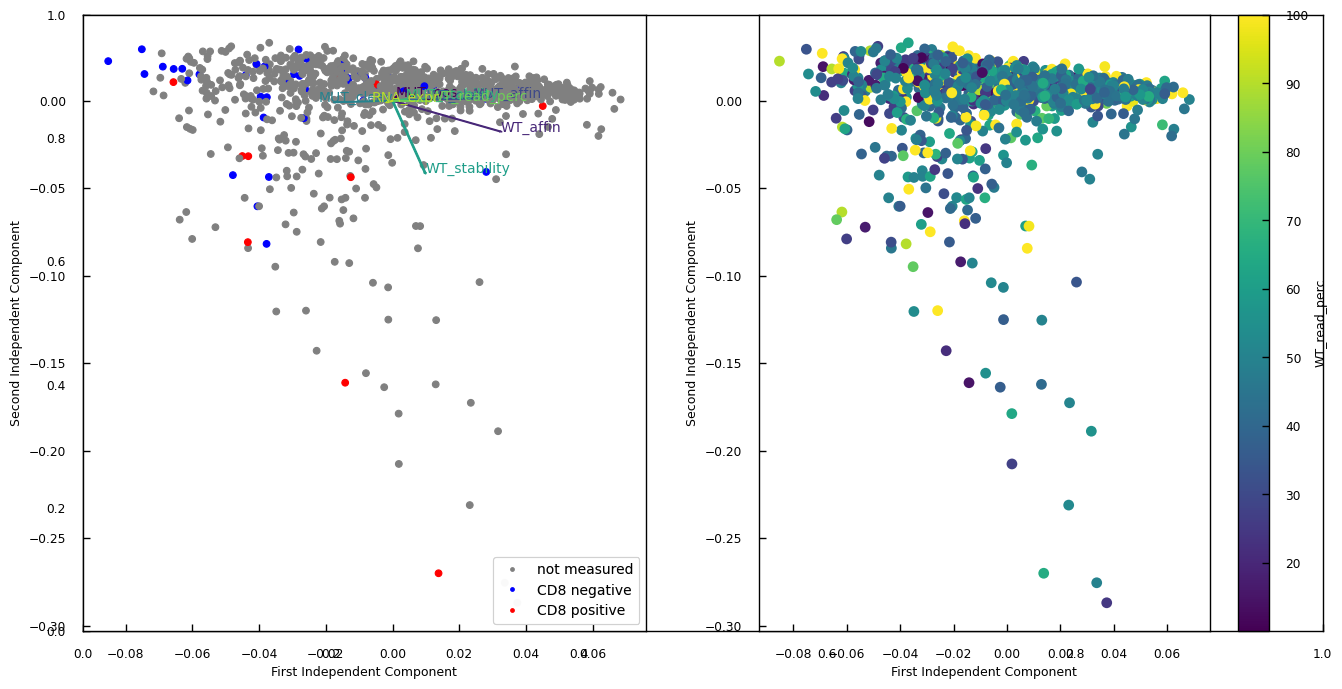

In [41]:
from sklearn.decomposition import FastICA

ica = FastICA(whiten='arbitrary-variance', random_state=1,n_components=9)

ica.fit(X_im_num)
x_ica = ica.transform(X_im_num)

plt.subplots(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(x_ica[:,0],x_ica[:,1],c=cols_im)
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')

feature_vectors = ica.components_.T

arrow_size = 0.08

# projections of the original features
cmap = cm.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    v = v/np.linalg.norm(v)
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.0008, head_length=0.0008, width=0.0005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, X_im_num.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    

handles = []
handles.append(Line2D([], [], color="gray", ls="", marker=".", label="not measured"))
handles.append(Line2D([], [], color="blue", ls="", marker=".", label="CD8 negative"))
handles.append(Line2D([], [], color="red", ls="", marker=".", label="CD8 positive"))
legend = plt.legend(handles=handles, loc=4, prop={'size': 10})
plt.gca().add_artist(legend)


plt.subplot(1,2,2)
feature = 'WT_read_perc'
sc =  plt.scatter(x_ica[:,0],x_ica[:,1],c=X_im_num[feature], s=60, lw=0, cmap='viridis')
plt.xlabel('First Independent Component')
plt.ylabel('Second Independent Component')
cb = plt.colorbar(sc)
cb.set_label(feature)


plt.show()


We see that ICA analysis found a clearly non-gaussian direction separating a group of points to the right (left plot). The corresponding feature is 'WT_read_perc'. Coloring the points by the 'WT_read_perc' value confirms this (right plot)

In [42]:
df_comp = pd.DataFrame(ica.components_,columns=X_im_num.columns)
df_comp

MUT_pos  WT_affin  MUT_affin  WT_cleav  MUT_cleav  WT_stability  \
0  0.000157  0.024854   0.020157  0.021152  -0.059883      0.003875   
1  0.000367 -0.013501   0.001197  0.001497  -0.002920     -0.016354   
2 -0.002460 -0.001105   0.000721 -0.123555   0.211291      0.002679   
3  0.000524  0.000439  -0.006022  0.007682  -0.010121      0.000434   
4 -0.001434 -0.000270  -0.009418 -0.054629  -0.157005      0.002294   
5  0.000972  0.051801  -0.059154  0.072367  -0.037869      0.007822   
6 -0.013106 -0.010636   0.009208 -0.059998   0.065832      0.000394   
7  0.000087 -0.014074   0.019806  0.001676  -0.004696     -0.025538   
8 -0.000223  0.005328   0.000719  0.008383  -0.016800      0.001660   

   MUT_stability  WT_read_perc  RNA_expr  
0       0.001452      0.000200 -0.000331  
1       0.000320     -0.000005 -0.000165  
2      -0.002252      0.000030 -0.000400  
3      -0.000553      0.001379 -0.002840  
4      -0.002735     -0.000014 -0.000514  
5      -0.008170     -0.000088 -0.002853  
6       0.000049      0.000038 -0.001857  
7       0.028843      0.000055  0.001129  
8      -0.003484      0.000345  0.018229

## PCA for breast cancer data <a class="anchor" id="bc-bullet"></a>

The breast cancer dataset is a classic dataset that was used in an early ML application ([Wolberg et al, Cencer Letters, 1994](https://www.sciencedirect.com/science/article/abs/pii/030438359490099X?via%3Dihub)). In this paper 
fine-needle aspirates from breast tissues were digitally scanned. The cell images were processed by a automated software and 10 features describing size and shape of the cell nuclei were extracted. For each feature the mean, the maximum and the standard deviation were measured resulting in 30 features.

/tmp/ipykernel_231587/2145094657.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


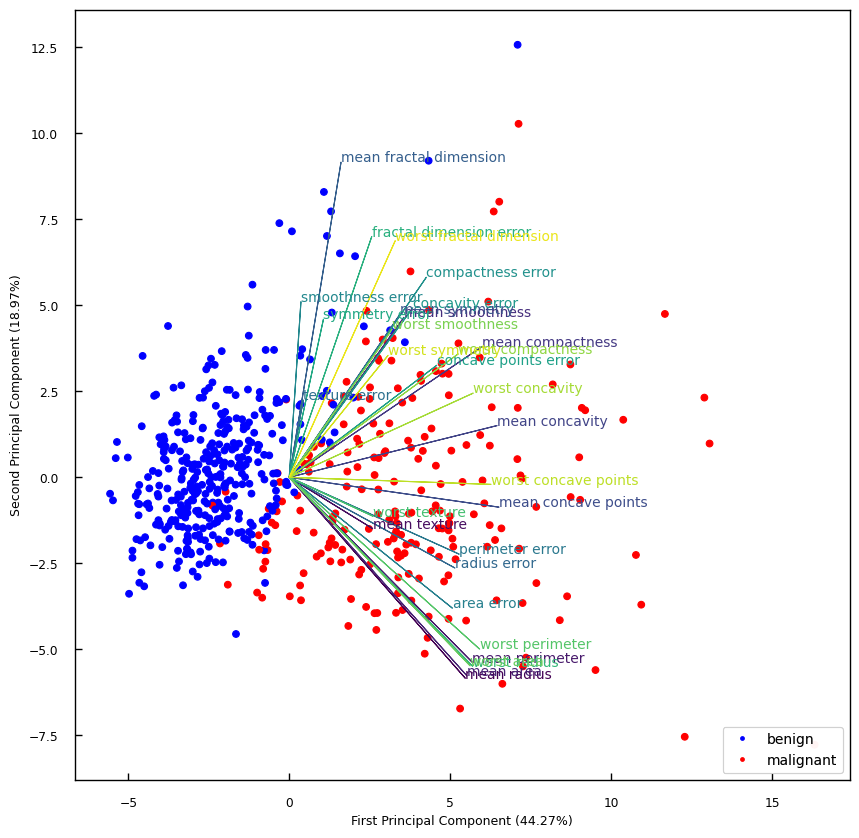

In [43]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

scaler = StandardScaler()
X_cancer = scaler.fit_transform(X_cancer)


df_cancer = pd.concat([pd.DataFrame(X_cancer,columns=cancer['feature_names']),\
                       pd.DataFrame(y_cancer,columns=['malignant'])],axis=1)

color_dict={0:'red', 1:'blue'}
cols_bcancer = [color_dict[y_cancer[i]] for i in range(df_cancer.shape[0])]

pca = PCA() #create an empty PCA object

from sklearn.preprocessing import StandardScaler

x_pca = pca.fit_transform(X_cancer) # calculates coordinates of row vectors in X in PC space

plt.figure(figsize=(10,10))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cols_bcancer)
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 25

# projections of the original features
cmap = cm.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, df_cancer.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    
handles = []
handles.append(Line2D([], [], color="blue", ls="", marker=".", label="benign"))
handles.append(Line2D([], [], color="red", ls="", marker=".", label="malignant"))
legend = plt.legend(handles=handles, loc=4, prop={'size': 10})
plt.gca().add_artist(legend)

    
plt.show()

## PCA for Iris data <a class="anchor" id="iris-bullet"></a>

In [44]:
from sklearn.datasets import load_iris
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                     pd.DataFrame(iris['target'],columns=['species'])],axis=1)

df_iris.head()


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species  
0        0  
1        0  
2        0  
3        0  
4        0

The Iris data is another dataset used many times in ML examples. In contains 150 cases of iris flowers devided into 3 species (setosa, versicolor, virginica) of 50 cases each. There are four features: sepal_length, sepal_width, petal_length, petal_width measured in cm.

/tmp/ipykernel_231587/1374368266.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


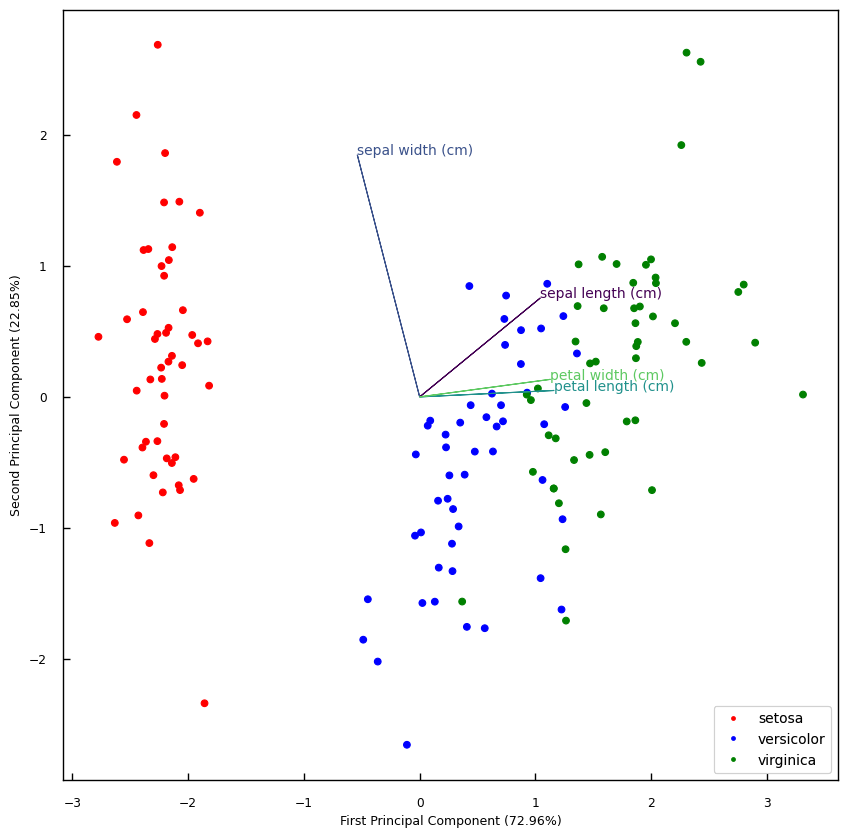

In [45]:
from sklearn.datasets import load_iris
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)

(X_iris, y_iris) = load_iris(return_X_y = True)

scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)


color_dict={0:'red', 1:'blue', 2:'green'}
cols_iris = [color_dict[y_iris[i]] for i in range(df_iris.shape[0])]

pca = PCA() #create an empty PCA object

from sklearn.preprocessing import StandardScaler

x_pca = pca.fit_transform(X_iris) # calculates coordinates of row vectors in X in PC space

plt.figure(figsize=(10,10))
plt.scatter(x_pca[:,0],x_pca[:,1],c=cols_iris)
plt.xlabel('First Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Second Principal Component ({0:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))

feature_vectors = pca.components_.T
arrow_size = 2

# projections of the original features
cmap = cm.get_cmap('viridis')
n = feature_vectors.shape[0]
for i, v in enumerate(feature_vectors): # enumerate over the rows of feature_vectors
    plt.arrow(0, 0, arrow_size * v[0], arrow_size * v[1], head_width=0.00008, head_length=0.00008, width=0.00005,
              color=cmap((1.0 * i) / n))
    text_pos = -0.005 if v[0] < 0 else 0.0001
    plt.text(v[0]*arrow_size+text_pos, v[1]*arrow_size+0.0001, df_iris.columns[i], 
            color=cmap((1.0 * i) / n),fontsize=10)
    
handles = []
handles.append(Line2D([], [], color="red", ls="", marker=".", label="setosa"))
handles.append(Line2D([], [], color="blue", ls="", marker=".", label="versicolor"))
handles.append(Line2D([], [], color="green", ls="", marker=".", label="virginica"))
legend = plt.legend(handles=handles, loc=4, prop={'size': 10})
plt.gca().add_artist(legend)

    
plt.show()

## Looking at the code <a class="anchor" id="code-bullet"></a>

If you would like to know what the function PCA.transform(), PCA.fit() or any other python function are doing exactly, it is a good idea to inspect the source code of these functions:

In [46]:
from sklearn.decomposition import PCA
import inspect

print(inspect.getsource(PCA.transform))

    def transform(self, X):
        """Apply dimensionality reduction to X.

        X is projected on the first principal components previously extracted
        from a training set.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            New data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        X_new : array-like of shape (n_samples, n_components)
            Projection of X in the first principal components, where `n_samples`
            is the number of samples and `n_components` is the number of the components.
        """
        xp, _ = get_namespace(X, self.components_, self.explained_variance_)

        check_is_fitted(self)

        X = self._validate_data(
            X, dtype=[xp.float64, xp.float32], accept_sparse=("csr", "csc"), reset=False
        )
        return self._transform(X, xp=xp, x_is_centered=False)

